# Computational Tests

This notebook is intended for running different kinds of analyses that would validate our reconstruction.

[1. Subsystem Overview and Analysis](#subsystems) <br>
[2. Context-specific Model Generation](#context_specific) <br>
[3. tSNE Comparison of Models](#tSNE) <br>
[4. Biomass prediction using exp. data](#biomass) <br>
[5. Flux Sampling Analysis](#fsa) <br>
[6. Pathway Enrichment Analysis](#pea) <br>

## 1. Subsystem Overview and Analysis <a id='subsystems'></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from google_sheet import GoogleSheet

In [ ]:
##### ----- Generate Subsystems datasets from Google Sheet ----- #####

#Credential file
KEY_FILE_PATH = 'credentials.json'

#CHO Network Reconstruction + Recon3D_v3 Google Sheet ID
SPREADSHEET_ID = '1MlBXeHIKw8k8fZyXm-sN__AHTRSunJxar_-bqvukZws'

# Initialize the GoogleSheet object
sheet = GoogleSheet(SPREADSHEET_ID, KEY_FILE_PATH)

# Read data from the Google Sheet
sheet_subsystems = 'Summary Systems'
sheet_reactions = 'Rxns'
subsystems = sheet.read_google_sheet(sheet_subsystems)
reactions_rec = sheet.read_google_sheet(sheet_reactions)

# Remove the total count
subsystems = subsystems.iloc[:-1, :]

In [ ]:
#### --- Pie Chart of the Amount of Reactions per System --- ####

subsystems["Number of Reactions"] = pd.to_numeric(subsystems["Number of Reactions"])

# Aggregate data by "System" and sum "Number of Reactions"
system_reactions = subsystems.groupby("System")["Number of Reactions"].sum()

# Set the figure and axes for more control
fig, ax = plt.subplots(figsize=(10, 7))

# Generate the pie chart again with the custom labels
patches, texts, autotexts = ax.pie(system_reactions, labels=system_reactions.index, autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '', startangle=140, colors=plt.cm.tab20.colors)

# Improve aesthetics
for text in texts + autotexts:
    text.set_color('black')
ax.set_title("Pie Chart of Number of Reactions by System", pad=30)  # Move the title upwards by increasing pad

# Set equal aspect ratio
ax.axis('equal')

# Save the plot
plt.savefig('../Plots/pie_chart_reactions_per_system.png')

# Display the plot
plt.show()

In [ ]:
# Generate the Sunburst Plot

fig = px.sunburst(subsystems, path=['System', 'Subsystems', 'Kegg Pathway'],
                  color='System')

# Convert to a Graph Objects figure
fig_go = go.Figure(fig)

# Update layout
fig_go.update_layout(width=1200, height=1000)

# Define font sizes
font_size_last_layer = 10
font_size_previous_layer = 15
default_font_size = 12

# Create a list to store font sizes
font_sizes = []

# Update font size for each level
for trace in fig_go.data:
    if isinstance(trace, go.Sunburst):
        for id in trace.ids:
            level = id.count("/")  # Determine level by the number of slashes in the id
            if level == 2:  # Last layer (Kegg Pathway)
                font_sizes.append(font_size_last_layer)
            elif level == 1:  # Previous layer (Subsystems)
                font_sizes.append(font_size_previous_layer)
            else:
                font_sizes.append(default_font_size)  # Default size for other layers

# Apply the font sizes to the figure
fig_go.update_traces(insidetextfont=dict(size=font_sizes))

# Save the figure
fig_go.write_html("../Plots/sunburst_subsystems.html")  # Save as interactive HTML file
fig_go.write_image("../Plots/sunburst_subsystems.png", width=1200, height=1000, scale=2)  # Increase resolution by setting scale parameter

# Show the plot
fig_go.show()

In [ ]:
# Create a susbsystem dictionary

subsystems = subsystems[['System', 'Subsystems']]
subsystems_dict = subsystems.groupby('System')['Subsystems'].apply(list).to_dict()

#### Auxotrophies

In [ ]:
from cobra.io import load_json_model

iCHO_path = "iCHO3595.json"
iCHO = load_json_model(iCHO_path)

In [ ]:
amino_acids = {
    "arginine": ["EX_arg_L_e", "EX_arg_D_e"],
    "asparagine": ["EX_asn_L_e", "EX_asn_D_e"],
    "cysteine": ["EX_cys_L_e", "EX_cys_D_e", "EX_Lcystin_e"],
    "histidine": ["EX_his_L_e", "EX_his_D_e"],
    "isoleucine": ["EX_ile_L_e", "EX_ile_D_e"],
    "leucine": ["EX_leu_L_e", "EX_leu_D_e"],
    "lysine": ["EX_lys_L_e", "EX_lys_D_e"],
    "methionine": ["EX_met_L_e", "EX_met_D_e"],
    "phenylalanine": ["EX_phe_L_e", "EX_phe_D_e"],
    "proline": ["EX_pro_L_e", "EX_pro_D_e"],
    "threonine": ["EX_thr_L_e", "EX_thr_D_e"],
    "tryptophan": ["EX_trp_L_e", "EX_trp_D_e"],
    "valine": ["EX_val_L_e", "EX_val_D_e"]
}
for amino_acid in amino_acids:
    # ----- Setup initial bounds -----
    for exchange_reaction in iCHO.exchanges:
        exchange_reaction.bounds = -10, 10

    # Arginine
    iCHO.reactions.get_by_id('GAUGE-R00557').bounds = 0, 10
    iCHO.reactions.get_by_id('GAUGE-R10107').bounds = 0, 0
    iCHO.reactions.get_by_id('GAUGE-R00558').bounds = 0, 0
    iCHO.reactions.get_by_id('GLYAMDTRc').bounds = 0, 0
    iCHO.reactions.get_by_id('GAUGE-R10107').bounds = 0, 0
    iCHO.reactions.get_by_id('EX_valarggly_e').bounds = 0, 10
    iCHO.reactions.get_by_id('ARGSL').bounds = 0, 0

    # Asparigine
    iCHO.reactions.get_by_id('ASNS1').bounds = 0, 0

    # Cysteine
    iCHO.reactions.get_by_id('r0129').bounds = 0, 0
    iCHO.reactions.get_by_id('EX_cgly_e').bounds = 0, 0
    iCHO.reactions.get_by_id('AMPTASECG').bounds = -10, 0
    iCHO.reactions.get_by_id('AMPTASECGe').bounds = -10, 0
    iCHO.reactions.get_by_id('CYSTGL').bounds = -10, 0
    iCHO.reactions.get_by_id('EX_HC00250_e').bounds = 0, 0
    iCHO.reactions.get_by_id('EX_sfcys_e').bounds = 0, 0

    # Histidine
    iCHO.reactions.get_by_id('VALTRPVALr').bounds = 0,0 

    # Isoleucine - DONE
    iCHO.reactions.get_by_id('EX_CE2916_e').bounds = 0,0 
    iCHO.reactions.get_by_id('EX_CE2915_e').bounds = 0,0 
    iCHO.reactions.get_by_id('ILETA').bounds = 0, 10
    iCHO.reactions.get_by_id('ILETAm').bounds = 0, 10

    # Leucine
    iCHO.reactions.get_by_id('LEULEULAPc').bounds = 0,0 
    iCHO.reactions.get_by_id('EX_leugly_e').bounds = 0,0 
    iCHO.reactions.get_by_id('EX_glyleu_e').bounds = 0,0 
    iCHO.reactions.get_by_id('LEUTA').bounds = 0, 10 
    iCHO.reactions.get_by_id('LEUTAm').bounds = 0, 10 
    iCHO.reactions.get_by_id('EX_CE5797_e').bounds = 0, 0

    # Lysine
    iCHO.reactions.get_by_id('EX_biocyt_e').bounds = 0,0 

    # Methionine
    iCHO.reactions.get_by_id('METS').bounds = -10, 0 
    iCHO.reactions.get_by_id('BHMT').bounds = -10, 0 
    iCHO.reactions.get_by_id('GAUGE-R00648').bounds = 0, 10 
    iCHO.reactions.get_by_id('UNK2').bounds = -10, 0 
    iCHO.reactions.get_by_id('UNK3').bounds = -10, 0 
    iCHO.reactions.get_by_id('TYRA').bounds = -10, 0 
    #iCHO.reactions.get_by_id('GAUGE-R06895').bounds = 0, 0 # Curated by MR with 1 score / Erased from the reconstruction

    # Phenylalanine
    iCHO.reactions.get_by_id('EX_CE5786_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_pheleu_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_glyphe_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_CE2917_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_CE5786_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_CE5789_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_phpyr_e').bounds = 0, 0 

    # Proline
    iCHO.reactions.get_by_id('EX_glypro_e').bounds = 0, 10
    iCHO.reactions.get_by_id('EX_progly_e').bounds = 0, 10
    iCHO.reactions.get_by_id('P5CR').bounds = 0, 0
    iCHO.reactions.get_by_id('P5CRxm').bounds = 0, 0
    iCHO.reactions.get_by_id('P5CRx').bounds = 0, 0
    iCHO.reactions.get_by_id('P5CRm').bounds = 0, 0
    iCHO.reactions.get_by_id('r1453').bounds = 0, 10

    # Threonine
    #iCHO.reactions.get_by_id('THRS').bounds = 0,0  # Erased from the reconstruction


    # Tryptophan
    iCHO.reactions.get_by_id('NBAHH_ir').bounds = 0,0  # Histidine hydrolase

    # Valine
    iCHO.reactions.get_by_id('EX_valarggly_e').bounds = 0, 10
    iCHO.reactions.get_by_id('EX_vallystyr_e').bounds = 0, 10
    iCHO.reactions.get_by_id('VALTA').bounds = 0, 10
    iCHO.reactions.get_by_id('VALTAm').bounds = 0, 10
    iCHO.reactions.get_by_id('EX_valval_e').bounds = 0, 10
    # -----------------------------------------

    for exchange_reaction in iCHO.exchanges:
        if exchange_reaction.id in amino_acids[amino_acid]:
            exchange_reaction.bounds = 0, 10
            # print(amino_acid, exchange_reaction.id, amino_acids[amino_acid])
    sol = iCHO.optimize()
    print(amino_acid, sol.objective_value)


In [ ]:
iCHO.metabolites.leu_L_c.summary()

#### Gene Deletion test

In [ ]:
import pandas as pd
from cobra.io import load_json_model, read_sbml_model
from cobra.flux_analysis import single_gene_deletion

#iCHO = load_json_model('iCHO3595_unblocked.json')
#iCHO1766 = read_sbml_model('../Data/Reconciliation/models/iCHOv1_final.xml')
iCHO2291 = read_sbml_model('../Data/Reconciliation/models/iCHO2291.xml')
#iCHO2441 = read_sbml_model('../Data/Reconciliation/models/iCHO2441.xml')

In [ ]:
gene_deletion_results = single_gene_deletion(iCHO2291)
essentiality_threshold = 0.01
essential_genes = gene_deletion_results[gene_deletion_results['growth'] < essentiality_threshold]

In [ ]:
# Print the essential genes
print(f"Number of essential genes for biomass: {len(essential_genes)}")
print("Essential genes for biomass production:")
for gene_idx in essential_genes.index:
    gene = iCHO2291.genes[gene_idx]
    print(f"{gene.id}: {gene.name}")

In [ ]:
import pickle
import cobra
import pandas as pd
from cobra.flux_analysis.variability import find_essential_genes
from cobra.io import load_json_model

In [ ]:
model = load_json_model('iCHO3595.json')

In [ ]:
# Load uptake and secretion rate "Intervals dict

with open('../Data/Uptake_Secretion_Rates/uptake_secretion_intrvl_wt_dict.pkl', 'rb') as file:
    uptsec_intrvl_wt = pickle.load(file)

with open('../Data/Uptake_Secretion_Rates/uptake_secretion_intrvl_zela_dict.pkl', 'rb') as file:
    uptsec_intrvl_zela = pickle.load(file)

In [ ]:
temp_dict = uptsec_intrvl_zela
time = 'P2 to P4'
objective = 'biomass_cho_s'

model.reactions.biomass_cho_s.bounds = temp_dict['exp_growth_rate'][time]
for rxn in model.boundary:
    
    # Models that are forced to secrete ethanol are not feasible
    if rxn.id == 'EX_etoh_e':
        rxn.bounds = (-0.1,0.1)
        continue

    # Replace the lower and upper bound with experimental data
    if rxn.id in temp_dict.keys():
        rxn.bounds = temp_dict[rxn.id][time]
        continue
    
    # Keep boundaries open for essential metabolites
    if rxn.id == 'EX_h2o_e':
        rxn.bounds = (-1000,1000)
        continue
    if rxn.id == 'EX_h_e':
        rxn.bounds = (-1000,1000)
        continue
    if rxn.id == 'EX_o2_e':
        rxn.bounds = (-1000,1000)
        continue
    if rxn.id == 'EX_hco3_e':
        rxn.bounds = (-1000,1000)
        continue
    if rxn.id == 'EX_so4_e':
        rxn.bounds = (-1000,1000)
        continue
    if rxn.id == 'EX_pi_e':
        rxn.bounds = (-1000,1000)
        continue

    # Boundaries from Sink reactions on iCHO_v1 (100 times lower)
    if rxn.id == 'SK_Asn_X_Ser_Thr_r':
        rxn.bounds = (-0.001,1000)
        continue
    if rxn.id == 'SK_Tyr_ggn_c':
        rxn.bounds = (-0.001,1000)
        continue
    if rxn.id == 'SK_Ser_Thr_g':
        rxn.bounds = (-0.001,1000)
        continue
    if rxn.id == 'SK_pre_prot_r':
        rxn.bounds = (-0.0006,1000)
        continue

    # Close uptake rates for the rest of the boundaries
    if rxn.id.startswith("EX_"):
        rxn.bounds = (0,1000) 
    if rxn.id.startswith("SK_"):
        rxn.bounds = (0,1000)
    if rxn.id.startswith("DM_"):
        rxn.bounds = (0,1000)
    
pfba_solution = cobra.flux_analysis.pfba(model)
pfba_obj = pfba_solution.fluxes[objective]
print(pfba_obj)

In [ ]:
sim_essential_genes = find_essential_genes(model)

In [ ]:
len(sim_essential_genes)

In [ ]:
# Load the dataset for the experimentally validated essential genes

exp_essential_genes = pd.read_csv('../Data/Gene_Essentiality/cho_essential_genes.csv', sep='\t')
exp_essential_genes['gene'] = exp_essential_genes['gene'].str.replace('__1$', '', regex=True)

In [ ]:
exp_essential_genes

In [ ]:
# Extract all gene names
all_gene_names = set()
for names in exp_essential_genes['gene']:
    for name in names.split('|'): #Extract the names of the genes with two aliases
        all_gene_names.add(name)

In [ ]:
essential_genes_model = []
for g in model.genes:
    if g.name in all_gene_names:
        essential_genes_model.append(g)

In [ ]:
len(essential_genes_model)

In [ ]:
set1 = set(sim_essential_genes)
set2 = set(essential_genes_model)

# Find shared elements
shared_elements = set1.intersection(set2)

# Find unique elements
unique_in_list1 = set1.difference(set2)
unique_in_list2 = set2.difference(set1)

In [ ]:
print("Shared genes between Exp Validated Essential Genes and Simulated Essential Genes:", len(shared_elements))
print("Unique genes in Simulated Essential Genes:", len(unique_in_list1))
print("Unique genes in Exp Validated Essentail Genes:", len(unique_in_list2))

In [ ]:
#iCHO3597 Total essential genes: 451 Sim essential genes: 54
#iCHO1766 Total essential genes: 229 Sim essential genes: 34
#iCHO2101 Total essential genes: 254 Sim essential genes: 51
#iCHO2291 Total essential genes: 340 Sim essential genes: 2

##### Essential for growth genes and comparison to (An optimised genome-wide, virus free CRISPR screen for mammalian cells)
https://pubmed.ncbi.nlm.nih.gov/34935002/

## 2. Simulation of reaction bounds for low confidence timepoint models <a id='context_specific'></a>

Here we use a matrix generated with rmf_CADRE to generate each context_specific model for each one of the conditions.

In [ ]:
import pickle
import pandas as pd
import numpy as np
from scipy.io import loadmat
from time import process_time

import pymCADRE
from pymCADRE.rank import rank_reactions
from pymCADRE.check import check_model_function
from pymCADRE.prune import prune_model

import cobra
from cobra.io import load_json_model
from cobra.exceptions import Infeasible

### Model and Data Loading

In [ ]:
# Load generic model
model = load_json_model('iCHO3K_unblocked.json')

In [ ]:
# Load uptake and secretion rate "Intervals dict
with open('../Data/Uptake_Secretion_Rates/uptake_secretion_raw_wt_dict.pkl', 'rb') as file:
    uptsec_wt = pickle.load(file)

### Constrain the model by the growth rate and low variability reactions

In [ ]:
time = "P0 to P2"

# Exclude 'exp_growth_rate' from reactions
reaction_fluxes = {rxn: fluxes for rxn, fluxes in uptsec_wt.items() if rxn != 'exp_growth_rate'}

# Compute variability for each reaction at the timepoint "P0 to P2"
reaction_variability = {}
for rxn_id, flux_dict in reaction_fluxes.items():
    # Collect all flux values for the specific timepoint "P0 to P2" across replicates
    flux_values = [v for (replicate, timepoint), v in flux_dict.items() if timepoint == time]
    # Compute standard deviation
    std_dev = np.std(flux_values)
    reaction_variability[rxn_id] = std_dev

# Now we have a dictionary of reaction IDs and their standard deviations at "P0 to P2"


In [ ]:
# Compute the threshold for low variability (e.g., reactions with std_dev less than 25th percentile)
variability_values = list(reaction_variability.values())
threshold = np.percentile(variability_values, 25)

# Select reactions with standard deviation below the threshold
low_variability_reactions = [rxn_id for rxn_id, std_dev in reaction_variability.items() if std_dev <= threshold]

# Reactions with high variability
high_variability_reactions = [rxn_id for rxn_id in reaction_fluxes if rxn_id not in low_variability_reactions]

print(f"Selected {len(low_variability_reactions)} reactions with low variability.")
print(f"Selected {len(high_variability_reactions)} reactions with high variability.")

In [ ]:
# Adjust the lower bound values according to the experimental growth rates
intervals = {'P0 to P2': 'P2'}
replicates = {'U1': 'Bio141', 'U2': 'Bio142', 'U3': 'Bio143'}
objective = 'biomass_cho_s'

# For storing simulated fluxes
simulated_fluxes = {}

# For storing modified reaction bounds
uptake_secretion_wt_sim_p0p2 = {}

for interval_key, interval_model_time in intervals.items():
    for rep_key, rep_suffix in replicates.items():
        with model as modified_model:
            
            # Keep boundaries open for essential metabolites
            for rxn in modified_model.boundary:
                if rxn.id in ['EX_h2o_e', 'EX_h_e', 'EX_o2_e', 'EX_hco3_e', 'EX_so4_e', 'EX_pi_e']:
                    rxn.bounds = (-1000, 1000)
                elif rxn.id in ['SK_Asn_X_Ser_Thr_r', 'SK_Tyr_ggn_c', 'SK_Ser_Thr_g', 'SK_pre_prot_r']:
                    rxn.bounds = (-0.001, 1000)
                elif rxn.id.startswith(("EX_", "SK_", "DM_")):
                    rxn.bounds = (0, 1000)  # Close uptake rates for others
            
            print(f"\nCalculating for WT Condition: {rep_key}, {interval_key}")
            exp_gr = uptsec_wt['exp_growth_rate'][(rep_key, interval_key)]
            print(f"Experimental growth rate: {exp_gr}")
            
            # Set constraints for reactions with low variability
            constrained_reactions = []
            unconstrained_reactions = []
            for reaction in modified_model.reactions:
                if reaction.id == 'EX_etoh_e':  # Model creates infeasible solutions when secreting etoh
                    continue
                if reaction.id == 'EX_bhb_e':  # Included manually based on exp data
                    reaction.bounds = (0.009, 0.012)
                elif reaction.id == 'EX_nh4_e':
                    reaction.bounds = (0.38, 0.41)
                elif reaction.id == 'EX_ac_e':
                    reaction.bounds = (0.014, 0.023)
                elif reaction.id == 'EX_ala_L_e':
                    reaction.bounds = (0.165, 0.174)
                elif reaction.id == 'EX_arg_L_e':
                    reaction.bounds = (-0.03, -0.02)
                elif reaction.id == 'EX_asn_L_e':
                    reaction.bounds = (-0.288, -0.188)
                elif reaction.id == 'EX_asp_L_e':
                    reaction.bounds = (0.04, 0.05)
                elif reaction.id == 'EX_2hb_e':
                    reaction.bounds = (0.012, 0.0135)
                elif reaction.id == 'EX_cys_L_e':
                    reaction.bounds = (-0.016, -0.010)
                elif reaction.id == 'EX_for_e':
                    reaction.bounds = (0.099, 0.105)
                elif reaction.id == 'EX_glc_e':
                    reaction.bounds = (-0.98, -0.78)
                elif reaction.id == 'EX_glu_L_e':
                    reaction.bounds = (0.035, 0.042)
                elif reaction.id == 'EX_gln_L_e':
                    reaction.bounds = (-0.71, -0.059)
                elif reaction.id == 'EX_gly_e':
                    reaction.bounds = (0.030, 0.035)
                elif reaction.id == 'EX_his_L_e':
                    reaction.bounds = (-0.0124, -0.007)
                elif reaction.id == 'EX_4hpro_e':
                    reaction.bounds = (-0.012, -0.005)
                elif reaction.id == 'EX_ile_L_e':
                    reaction.bounds = (-0.025, -0.015)
                elif reaction.id == 'EX_lac_L_e':
                    reaction.bounds = (1.8, 1.93)
                elif reaction.id == 'EX_leu_L_e':
                    reaction.bounds = (-0.039, -0.025)
                elif reaction.id == 'EX_lys_L_e':
                    reaction.bounds = (-0.047, -0.019)
                elif reaction.id == 'EX_met_L_e':
                    reaction.bounds = (-0.015, -0.011)
                elif reaction.id == 'EX_phe_L_e':
                    reaction.bounds = (-0.025, -0.019)
                elif reaction.id == 'EX_pro_L_e':
                    reaction.bounds = (0.01, 0.14)
                elif reaction.id == 'EX_5oxpro_e':
                    reaction.bounds = (0.28, 0.33)
                elif reaction.id == 'EX_pyr_e':
                    reaction.bounds = (-0.088, -0.07)
                elif reaction.id == 'EX_ser_L_e':
                    reaction.bounds = (-0.14, -0.11)
                elif reaction.id == 'EX_thr_L_e':
                    reaction.bounds = (-0.026, -0.007)
                elif reaction.id == 'EX_trp_L_e':
                    reaction.bounds = (-0.012, -0.006)
                elif reaction.id == 'EX_tyr_L_e':
                    reaction.bounds = (0.008, 0.015)
                elif reaction.id == 'EX_val_L_e':
                    reaction.bounds = (-0.035, -0.02)
                elif reaction.id == 'ATPM':  # Add ATP Maintenance Cost
                    reaction.lower_bound = 6
                else:
                    continue

            
            # Constrain biomass reaction to experimental growth rate
            # Allowing a small deviation (e.g., ±10%) to account for model limitations
            growth_lb = exp_gr * 0.9
            growth_ub = exp_gr * 1.1
            modified_model.reactions.get_by_id(objective).bounds = (growth_lb, growth_ub)
            print(f"Biomass reaction bounds set to: {growth_lb}, {growth_ub}")

            
            
            # Run pFBA
            try:
                pfba_solution = cobra.flux_analysis.pfba(modified_model)
                pfba_obj = pfba_solution.fluxes[objective]
                print(f"Solution status: {pfba_solution.status}")
                print(f"Objective value (growth rate): {pfba_obj}")

                # Capture simulated uptake and secretion rates
                simulated_flux = {}
                for rxn in modified_model.reactions:
                    if rxn.id in uptsec_wt.keys():
                        uptake_secretion_wt_sim_p0p2[rxn.id] = {}
                        uptake_secretion_wt_sim_p0p2[rxn.id][interval_key] = rxn.bounds
                        
                        flux = pfba_solution.fluxes.get(rxn.id, 0)
                        simulated_flux[rxn.id] = flux
                simulated_fluxes[(rep_key, interval_key)] = simulated_flux
                uptake_secretion_wt_sim_p0p2['exp_growth_rate'] = {}
                uptake_secretion_wt_sim_p0p2['exp_growth_rate'][interval_key] = (0.034,0.037)
                print("Simulated uptake and secretion rates:")
                for rxn_id, flux in simulated_flux.items():
                    print(f"{rxn_id}: {flux}")

                uptake_secretion_wt_sim_p0p2

            except Infeasible:
                print(f"Infeasible solution for replicate {rep_key} interval {interval_key}")
                # Optionally, you can implement a procedure to relax constraints or identify problematic reactions


In [ ]:
with open('../Data/Uptake_Secretion_Rates/uptake_secretion_wt_sim_p0p2.pkl', 'wb') as file:
    pickle.dump(uptake_secretion_wt_sim_p0p2, file)

## 3. ATP Generation loops removal

In [ ]:
from itertools import chain
import pickle
import numpy as np
from optlang.symbolics import Zero
import pandas as pd

import cobra
from cobra.util import create_stoichiometric_matrix
from cobra.io import load_json_model

#### Loading and Constraining Model

In [ ]:
model = load_json_model('iCHO3595_unblocked.json')

In [ ]:
with open('../Data/Uptake_Secretion_Rates/uptake_secretion_raw_zela_dict.pkl', 'rb') as file:
    uptsec_zela = pickle.load(file)

#### ATP loops removal

In [ ]:
# First, define your list of reaction IDs
atp_loop_reactions = [
    'SCP22x','TMNDNCCOAtx','OCCOAtx','r0391','BiGGRxn67','r2247','r2280',
    'r2246','r2279','r2245','r2305','r2317','r2335','HMR_0293','HMR_7741',
    'r0509','r1453','HMR_4343','ACONTm','PDHm','r0426','r0383','r0555',
    'r1393','NICRNS','GAUGE-R00648','GAUGE-R03326','GapFill-R08726','RE2915M',
    'HMR_3288','HMR_1325','HMR_7599','r1431','r1433','RE2439C','r0082','r0791',
    'r1450','GAUGE-R00270','GAUGE-R02285','GAUGE-R04283','GAUGE-R06127','GAUGE-R06128',
    'GAUGE-R06238','GAUGE-R00524','RE3477C','AAPSAS','RE3347C','HMR_0960','HMR_0980',
    'RE3476C','r0708','r0777','r0084','r0424','r0698','3HDH260p','HMR_3272','ACOAD183n3m',
    'HMR_1996','GapFill-R01463','GapFill-R04807','r1468','r2435','r0655','r0603','r0541',
    'RE0383C','HMR_1329','TYRA','NRPPHRt_2H','GAUGE-R07364','GapFill-R03599','ARD',
    'RE3095C','RE3104C','RE3104R','ACONT','ICDHxm','ICDHy','AKGDm','r0083',
    'r0425','r0556','NH4t4r','PROPAT4te','r0085','r0156','r0464','ABUTDm',
    'OIVD1m','OIVD2m','OIVD3m','r2194','r2202','HMR_9617','r2197','r2195',
    '2OXOADOXm','r2328','r0386','r0451','FAS100COA','FAS120COA','FAS140COA',
    'FAS80COA_L','r0604','r0670','r2334','r0193','r0595','r0795','GLYCLm',
    'MACACI','r2193','r0779','r0669','UDCHOLt','r2146','r2139'
]

# Function to knock out reactions in the model
def knock_out_reactions(model, reactions_to_knockout):
    for rxn_id in reactions_to_knockout:
        try:
            rxn = model.reactions.get_by_id(rxn_id)
            rxn.knock_out()
        except KeyError:
            print(f"Reaction {rxn_id} not found in the model.")

# Set up the boundary conditions as per your code
def set_boundary_conditions(model, exp_boundaries, batch, timepoint):
    for rxn in model.boundary:
        if rxn.id in ['EX_h2o_e', 'EX_h_e', 'EX_o2_e', 'EX_hco3_e', 'EX_so4_e', 'EX_pi_e']:
            rxn.bounds = (-1000, 1000)
        elif rxn.id in ['SK_Asn_X_Ser_Thr_r', 'SK_Tyr_ggn_c', 'SK_Ser_Thr_g', 'SK_pre_prot_r']:
            rxn.bounds = (-0.001, 1000)
        elif rxn.id.startswith(("EX_", "SK_", "DM_")):
            rxn.bounds = (0, 1000)  # Close uptake rates for others
    
    for reaction in model.reactions:
        if reaction.id == 'EX_etoh_e': #Model creates infeasible solutions when secreting etoh
            continue
        for r,v in uptsec_zela.items():
            if reaction.id == r:
                reaction.upper_bound = 1000
                reaction.lower_bound = v[(batch, timepoint)]

# Function to run pFBA and return ATPM and growth rate
def run_pfba(model, objective_id='biomass_cho_s'):
    model.objective = objective_id
    solution = cobra.flux_analysis.pfba(model)
    growth_rate = solution.fluxes.get(objective_id, None)
    return growth_rate

# Function to find the ATPM lower bound where growth rate changes
def find_atpm_threshold(model):
    # Start from 0 and incrementally increase ATPM lower bound
    for atpm_bound in range(30, -1, -1):
        try:
            with model as test_model:
                baseline_growth_rate = run_pfba(test_model)
                test_model.reactions.get_by_id('ATPM').lower_bound = atpm_bound
                growth_rate = run_pfba(test_model)
                
                # Check if growth rate changes compared to the baseline
                if round(growth_rate, 6) != round(baseline_growth_rate, 6):
                    print(f"Growth rate altered at ATPM lower bound: {atpm_bound}")
                    return atpm_bound
        except Exception as e:
            print(f"Infeasible solution for bound: {atpm_bound}, {e}")
    return 0  # If no change, default to 0


# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Batch', 'Timepoint', 'Reaction', 'Growth Rate', 'Growth Changed'])

timepoints = ['P0 to P2','P2 to P4','P4 to P6','P6 to P8']
batches = ['U4','U5','U6','U7','U8']

for timepoint in timepoints:
    for batch in batches:
        print(f'Analising batch {batch} at timepoint {timepoint}')
        try:
            # Establish baseline with all reactions knocked out
            with model as base_model:
                set_boundary_conditions(base_model, uptsec_zela, batch, timepoint)
                knock_out_reactions(base_model, atp_loop_reactions)
    
                # Find the ATPM lower bound where the growth rate changes
                atpm_threshold = find_atpm_threshold(base_model)
                
                # Add ATP Maintenance Cost
                base_model.reactions.get_by_id('ATPM').lower_bound = atpm_threshold
                
                # Run pFBA
                base_growth_rate = run_pfba(base_model)
                print(f'Baseline Growth Rate: {base_growth_rate}')
                
            # Now, iteratively "knock in" each reaction and test
            results = []
            for rxn_id in atp_loop_reactions:
                with model as test_model:
                    set_boundary_conditions(test_model, uptsec_zela, batch, timepoint)
                    # Knock out all reactions except the current one
                    reactions_to_knockout = [rid for rid in atp_loop_reactions if rid != rxn_id]
                    knock_out_reactions(test_model, reactions_to_knockout)
                    
                    # Add ATP Maintenance Cost
                    test_model.reactions.get_by_id('ATPM').lower_bound = atpm_threshold
            
                    # Run pFBA
                    growth_rate = run_pfba(test_model)
                    
                    # Check if there's a change compared to the baseline
                    growth_changed = round(growth_rate,6) != round(base_growth_rate,6)
            
                    # Create a new row and concatenate with the existing DataFrame
                    new_row = pd.DataFrame([{
                        'Batch': batch,
                        'Timepoint': timepoint,
                        'Reaction': rxn_id,
                        'Growth Rate': growth_rate,
                        'Growth Changed': growth_changed
                    }])
                    
                    results_df = pd.concat([results_df, new_row], ignore_index=True)
                    
                    print(f'Tested reaction: {rxn_id}')
                    print(f'Growth Rate: {growth_rate}')
                    print(f'Growth Changed: {growth_changed}')
                    print('---')
        except Exception as e:
            print(f"Error with batch {batch} and timepoint {timepoint}: {e}")

In [ ]:
# Group by Reaction and check if all Growth Changed values are False
consistent_non_affecting_reactions = results_df.groupby('Reaction')['Growth Changed'].apply(lambda x: (x == False).all())
# Filter reactions that are consistently False across all batches and timepoints
reactions_never_affecting_growth = consistent_non_affecting_reactions[consistent_non_affecting_reactions].index.tolist()
# Removing the specified reactions
filtered_atp_loop_reactions = [rxn for rxn in atp_loop_reactions if rxn not in reactions_never_affecting_growth]

In [ ]:
filtered_atp_loop_reactions = [
    'SCP22x','TMNDNCCOAtx','OCCOAtx','r0391','BiGGRxn67','r2247','r2246','r2245','r2317','HMR_0293',
    'HMR_7741','r1453','r1393','NICRNS','GapFill-R08726','RE2915M','HMR_3288','HMR_1325','RE2439C',
 'r1450','RE3477C','AAPSAS','r0698','3HDH260p','HMR_3272','ACOAD183n3m','GapFill-R01463','r1468',
 'r0655','r0603','r0541','HMR_1329','GapFill-R03599','AKGDm','r0556','OIVD1m','OIVD3m','2OXOADOXm',
 'r0386','r0451','GLYCLm','MACACI'
]

In [ ]:
#########################################
# Pablo's modification
#########################################
from tqdm import tqdm


def get_atp_related_reactions(model, atp_mets):
    """ Get reactions associated with ATP and related metabolites like GTP, GDP, etc. """
    atp_rxns_indices = set()  # Use set to avoid duplicates
    for met in atp_mets:
        for reac in met.reactions:
            if any(x in reac.reactants + reac.products for x in atp_mets):
                atp_rxns_indices.add(reac.id)
    return list(atp_rxns_indices)

def find_low_flux_reactions(model, atp_rxns_indices, atp_met_indices, stoich_matrix, consumption_cutoff=2e-12):
    """ Identify reactions with low ATP or related metabolite consumption flux. """
    atp_consumption_idx = []
    for atp_rxn in atp_rxns_indices:
        reaction = model.reactions.get_by_id(atp_rxn)
        for met in atp_met_indices:
            # Check for both ATP and GTP-related consumption (stoichiometric coefficient < 0)
            if stoich_matrix[model.metabolites.index(met), model.reactions.index(reaction)] < 0:
                atp_consumption_idx.append(atp_rxn)
                break
    return atp_consumption_idx

def perform_fba_for_max_atp(model, oxpho_rxns):
    """ Set FBA objective to maximize ATP production. """
    reaction_variables = ((rxn.forward_variable, rxn.reverse_variable) for rxn in oxpho_rxns)
    variables = chain(*reaction_variables)
    model.objective = model.problem.Objective(Zero, direction="max", sloppy=True, name="maxATP")
    model.objective.set_linear_coefficients({v: 1.0 for v in variables})
    return model.optimize()

def remove_cyclic_atp_reactions(model, atp_rxns_to_remove, biomass_rxn):
    """ Remove reactions consuming ATP in a cyclic fashion and check for safety. """
    
    safe_rxn_irrev = []

    # Copy the original model
    temp_model = model.copy()

    # Set the objective for the temporary model
    temp_model.objective = biomass_rxn
    sol_bio_control = temp_model.optimize()

    # Cumulative list of safe reactions to remove or modify
    candidate_safe_rmv = []
    candidate_safe_irrev = []

    for rxn_id in tqdm(atp_rxns_to_remove, desc="Processing reactions"):
        with temp_model:
            # Try to make the reaction irreversible
            if temp_model.reactions.get_by_id(rxn_id).lower_bound != 0:
                temp_model.reactions.get_by_id(rxn_id).bounds = (0, 1000)
                sol_bio_temp = temp_model.optimize()
                
                if (round(sol_bio_temp.objective_value, 5) == round(sol_bio_control.objective_value, 5)):
                    candidate_safe_irrev.append(rxn_id)
                    
                    # Test cumulative effect of all candidate modifications
                    for rxn in candidate_safe_irrev:
                        temp_model.reactions.get_by_id(rxn).bounds = (0, 1000)
                    sol_bio_cumulative = temp_model.optimize()

                    # If the cumulative effect is still safe, add to the final modification list
                    if round(sol_bio_cumulative.objective_value, 5) == round(sol_bio_control.objective_value, 5):
                        safe_rxn_irrev = list(candidate_safe_irrev)
                    else:
                        # If not safe, undo the last added irreversible modification
                        candidate_safe_irrev.remove(rxn_id)
                        print(f"Making {rxn_id} irreversible is not safe, reverting.")

    # Make irreversible reactions that can be safely modified
    for rxn in safe_rxn_irrev:
        if model.reactions.get_by_id(rxn).lower_bound != 0:
            model.reactions.get_by_id(rxn).bounds = (0, 1000)
    
    return model, safe_rxn_irrev

# Set objectives
biomass_rxn = 'biomass_cho_s'
model.objective = biomass_rxn
biomass_control = model.optimize('maximize')

# Find ATP related reactions
atp_related_mets = ['atp_c', 'atp_n', 'atp_m', 'atp_x', 'atp_l', 'atp_g', 'atp_r', 'atp_e', 'datp_c', 'dadp_c', 'gtp_c', 'gdp_c',
                    'utp_c', 'udp_c', 'ctp_c', 'cdp_c', 'ump_c', 'mlthf_c', 'mlthf_m', 'dgtp_c', 'dgdp_c', 'adxrd_c', 'adxrd_m',
                    'adxo_2_2_m', 'adxo_2_2_c', 'udpg_c', 'udpgal_c', 'succ_m', 'succoa_m', '4met2obut_c', 'q10h2_m', 'q10_m']
atp_met_indices = [model.metabolites.get_by_id(met) for met in atp_related_mets]
atp_rxns_indices = get_atp_related_reactions(model, atp_met_indices)

# Create stoichiometric matrix
stoich_matrix = create_stoichiometric_matrix(model)
atp_consumption_idx = find_low_flux_reactions(model, atp_rxns_indices, atp_met_indices, stoich_matrix)

# Maximize ATP production
oxpho_rxns = [r for r in model.reactions if 'OXIDATIVE PHOSPHORYLATION' in r.subsystem]
solution_maxATP = perform_fba_for_max_atp(model, oxpho_rxns)

# Check flux of ATP consuming reactions
atp_loop_rxn_rmv = []

model.objective = biomass_rxn
sol = model.optimize('maximize')
atp_rate = np.vstack([sol[atp_consumption_idx], solution_maxATP[atp_consumption_idx]])

# Find low flux ATP reactions
atp_rxn_lowFlux = [rxn_id for rxn_id, rate in zip(atp_consumption_idx, np.sum(atp_rate, axis=0)) if rate <= 2e-12]

# Filter protected subsystems and exchanges
protected_subsystems = ['BIOMASS', 'OXIDATIVE PHOSPHORYLATION']
atp_loop_rxn_rmv += [rxn for rxn in atp_rxn_lowFlux if model.reactions.get_by_id(rxn).subsystem not in protected_subsystems]

# Ensure ATPM and exchange reactions are not removed
atp_loop_rxn_rmv = [r_id for r_id in atp_loop_rxn_rmv if r_id != 'ATPM' and not r_id.startswith("EX_")]

# Remove duplicates in the list
atp_loop_rxn_rmv = set(atp_loop_rxn_rmv)

# Remove cyclic ATP reactions and check safety
pruned_model, safe_rxn_irrev = remove_cyclic_atp_reactions(model, atp_loop_rxn_rmv, biomass_rxn)

print(f"Reactions consuming ATP in a cyclic fashion and safe to make irreversible: {len(safe_rxn_irrev)}")

# Final biomass
pruned_model.objective = biomass_rxn
sol_bio = pruned_model.optimize('maximize')

print(f"Old Bio: {biomass_control.objective_value:.3f}, New Bio: {sol_bio.objective_value:.3f}")

## 3. tSNE Comparison of Models <a id='tSNE'></a>
Here we visualize the relationships across the reaction structures of individual cell lines to reveal of similar cell types group together

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mstats

from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

from collections import defaultdict
from cobra.io import load_matlab_model

### Define functions for model comparison

In [2]:
def compare_multiple_cobra_models(models, print_results=False, plot_results=False, group_vector=None, func_compare=False, task_file=None, subsystem_mapping=None,
                                  subsystem_filter=None, condition_filter=None, save_path=None, cluster_rows=False, cluster_cols=False):
    """
    Compares two or more condition-specific COBRA models in terms of reactions and subsystems.
    
    Parameters:
        models (list): List of `cobra.Model` objects to compare.
        print_results (bool): If True, prints the results. Default is False.
        plot_results (bool): If True, generates plots. Default is False.
        group_vector (list): List or array that groups similar models. Default is None.
        func_compare (bool): If True, performs functional comparison. Default is False.
        task_file (str): Name of the task file for functional comparison. Default is None.
        subsystem_mapping (dict): Mapping from subsystem names to grouped system names.
    
    Returns:
        comp_struct (dict): A dictionary containing the comparison results.
    """

    # Check if there are at least two models
    if len(models) <= 1:
        raise ValueError("Cannot compare only one model. Provide at least two models.")

    # Initialize comp_struct to store the comparison results
    comp_struct = {
        'modelIDs': [],
        'reactions': {},
        'subsystems': {},
        'structComp': None,
        'structCompMap': None,
        'funcComp': None
    }

    # Get model IDs
    comp_struct['modelIDs'] = [model.id for model in models]

    # Assign labels based on the model names
    labels = assign_labels_based_on_name(comp_struct['modelIDs'])

    # Group models by WT and ZeLa
    wt_models = [model for model in models if 'WT' in model.id]
    zela_models = [model for model in models if 'ZeLa' in model.id]

    # Compare subsystems with grouping
    print("\nComparing subsystem utilization")
    subsystems, subsystem_matrix = compare_cobra_field(models, 'subsystem', normalize=True, subsystem_mapping=subsystem_mapping)
    comp_struct['subsystems'] = {'ID': subsystems, 'matrix': subsystem_matrix}

    if print_results:
        print("\nComparison of grouped subsystem populations:")
        df = pd.DataFrame(subsystem_matrix, index=subsystems, columns=comp_struct['modelIDs'])
        print(df.head(15))

    if plot_results:
        # Compute the average usage of subsystems for WT and ZeLa groups
        wt_indices = [i for i, model_id in enumerate(comp_struct['modelIDs']) if 'WT' in model_id]
        zela_indices = [i for i, model_id in enumerate(comp_struct['modelIDs']) if 'ZeLa' in model_id]

        wt_avg = np.mean(subsystem_matrix[:, wt_indices], axis=1)
        zela_avg = np.mean(subsystem_matrix[:, zela_indices], axis=1)

        # Calculate the absolute differences between WT and ZeLa
        differences = np.abs(wt_avg - zela_avg)

        # Sort subsystems by the biggest differences
        sorted_indices = np.argsort(differences)[::-1]  # Sort in descending order of differences
        sorted_subsystems = [subsystems[i] for i in sorted_indices]
        sorted_matrix = subsystem_matrix[sorted_indices, :]

        # Plot heatmap for the sorted matrix
        plot_heatmap(sorted_matrix, sorted_subsystems, comp_struct['modelIDs'], "Systems Differences: WT vs ZeLa", save_path=save_path, subsystem_filter=subsystem_filter, condition_filter=condition_filter,
                     cluster_rows=cluster_rows, cluster_cols=cluster_cols)

    # Compare model structures
    print("\nComparing model structures")
    reactions, reaction_matrix = compare_cobra_field(models, 'reaction')
    comp_struct['reactions'] = {'IDs': reactions, 'matrix': reaction_matrix}

    # t-SNE projection for structure comparison
    n_models = reaction_matrix.T.shape[0]  # Get the number of models

    # Set perplexity to be less than the number of models
    perplexity = min(n_models - 1, 2)  # Ensure that perplexity is valid

    tsne = TSNE(metric='hamming', n_components=2, perplexity=perplexity, random_state=42)
    tsne_projection = tsne.fit_transform(reaction_matrix.T)
    comp_struct['structCompMap'] = tsne_projection

    if plot_results:
        plot_tsne(tsne_projection, labels=labels, model_ids=comp_struct['modelIDs'], title="Network Topology t-SNE Projection", save_path=save_path)

    # Functional comparison (if required)
    if func_compare and task_file:
        print("\nChecking model performance on specified tasks.")
        task_report = perform_functional_comparison(models, task_file)
        comp_struct['funcComp'] = task_report
        if plot_results:
            task_matrix = np.array([report['ok'] for report in task_report])
            plot_heatmap(task_matrix, comp_struct['modelIDs'], [task['description'] for task in task_report[0]['tasks']], "Functional Comparison")

    return comp_struct


def compare_cobra_field(models, field, normalize=False, subsystem_mapping=None):
    """
    Compares COBRA models by a specified field (e.g., reactions, subsystems) and returns
    a matrix indicating the number of reactions per field (e.g., subsystems) for each model.

    Parameters:
        models (list): List of `cobra.Model` objects.
        field (str): The field to compare ('reaction', 'subsystem').
        normalize (bool): If True and field is 'subsystem', applies Z-score normalization.
        subsystem_mapping (dict): Mapping from subsystem names to grouped system names.

    Returns:
        id_list (list): List of unique field entries (reactions or subsystems).
        comp_matrix (numpy array): Comparison matrix for the field.
    """
    if field == 'reaction':
        # For reactions, collect all unique reaction IDs
        field_entries = [set(rxn.id for rxn in model.reactions) for model in models]
    elif field == 'subsystem':
        # For subsystems, collect all unique subsystems
        if subsystem_mapping is not None:
            # Reverse the mapping to get a mapping from subsystem names to group names
            reverse_mapping = {}
            for group, subsystems in subsystem_mapping.items():
                for subsystem in subsystems:
                    reverse_mapping[subsystem.upper()] = group  # Uppercase for case-insensitive matching
            field_entries = []
            for model in models:
                mapped_subsystems = set()
                for rxn in model.reactions:
                    if rxn.subsystem:
                        subsystem_name = rxn.subsystem.upper()
                        group = reverse_mapping.get(subsystem_name)
                        if group:
                            mapped_subsystems.add(group)
                field_entries.append(mapped_subsystems)
        else:
            field_entries = [set(rxn.subsystem for rxn in model.reactions if rxn.subsystem) for model in models]
    else:
        raise ValueError("Invalid field. Supported fields are 'reaction' and 'subsystem'.")

    # Create a sorted list of all unique field entries
    id_list = sorted(set.union(*field_entries))

    # Initialize a matrix to store the number of reactions per field (subsystem or reaction)
    comp_matrix = np.zeros((len(id_list), len(models)), dtype=int)

    # Fill the comparison matrix
    for i, model in enumerate(models):
        if field == 'reaction':
            # Create a set of reaction IDs in the model
            reaction_ids = set(rxn.id for rxn in model.reactions)
            for j, entry in enumerate(id_list):
                if entry in reaction_ids:
                    comp_matrix[j, i] = 1  # Presence of the reaction
        elif field == 'subsystem':
            # Create a dictionary to count reactions per subsystem
            subsystem_counts = {subsystem: 0 for subsystem in id_list}
            for rxn in model.reactions:
                if rxn.subsystem:
                    if subsystem_mapping is not None:
                        subsystem_name = rxn.subsystem.upper()
                        group = reverse_mapping.get(subsystem_name)
                        if group:
                            subsystem_counts[group] += 1
                    else:
                        subsystem_counts[rxn.subsystem] += 1
            # Update the matrix with subsystem counts
            for j, entry in enumerate(id_list):
                comp_matrix[j, i] = subsystem_counts.get(entry, 0)

    # Apply Z-score normalization only for subsystems if requested
    if field == 'subsystem' and normalize:
        comp_matrix = z_score_normalize(comp_matrix)

    return id_list, comp_matrix


def z_score_normalize(matrix):
    """
    Applies Z-score normalization to each row of the matrix (i.e., for each subsystem).

    Parameters:
        matrix (numpy array): The comparison matrix to normalize.

    Returns:
        normalized_matrix (numpy array): Z-score normalized matrix.
    """
    
    # Compute Z-scores along the rows (axis=1)
    mean_values = np.mean(matrix, axis=1, keepdims=True)
    std_values = np.std(matrix, axis=1, keepdims=True)

    # Avoid division by zero in case any row has zero standard deviation
    std_values[std_values == 0] = 1

    normalized_matrix = (matrix - mean_values) / std_values
    return normalized_matrix


def plot_heatmap(data, row_labels, col_labels, title, vmin=-2, vmax=2, save_path=None, 
                           subsystem_filter=None, condition_filter=None, method='average', metric='euclidean',
                           standardize=False, cluster_rows=True, cluster_cols=False):
    """
    Generates a clustered heatmap for the given data, optionally filtering by subsystems and conditions.

    Parameters:
        data (numpy array): Data matrix to plot.
        row_labels (list): Labels for rows (subsystems).
        col_labels (list): Labels for columns (conditions).
        title (str): Title of the plot.
        vmin (float): Minimum value for the color scale. Default is -2.
        vmax (float): Maximum value for the color scale. Default is 2.
        save_path (str): Path to save the plot. Default is None (no saving).
        subsystem_filter (list): List of subsystem names to include in the plot. Default is None (all subsystems).
        condition_filter (list): List of condition names (column labels) to include. Default is None (all conditions).
        method (str): Linkage method for clustering ('single', 'complete', 'average', 'ward'). Default is 'average'.
        metric (str): Distance metric for clustering ('euclidean', 'cityblock', 'cosine', etc.). Default is 'euclidean'.
        standardize (bool): Whether to standardize the data before clustering. Default is False.
    """

    # Filter rows by specified subsystems if a filter is provided
    if subsystem_filter:
        subsystem_indices = [i for i, label in enumerate(row_labels) if label in subsystem_filter]
        data = data[subsystem_indices, :]
        row_labels = [row_labels[i] for i in subsystem_indices]

    # Filter columns by specified conditions if a filter is provided
    if condition_filter:
        condition_indices = [i for i, label in enumerate(col_labels) if label in condition_filter]
        data = data[:, condition_indices]
        col_labels = [col_labels[i] for i in condition_indices]

    # Check if the filtered data is valid for plotting
    if data.shape[0] < 2 or data.shape[1] < 2:
        print(f"Insufficient data for clustered heatmap in '{title}'. Need at least 2 subsystems and 2 conditions.")
        return  # Skip plotting if data is too small

    # Optional standardization
    if standardize:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)

    # Create a pandas DataFrame for easier handling in seaborn
    df = pd.DataFrame(data, index=row_labels, columns=col_labels)

    # **Remove rows where all values are zero, and update row_labels
    df = df.loc[(df != 0).any(axis=1)]
    row_labels = df.index.tolist()
    
    # Plotting the clustered heatmap
    g = sns.clustermap(df, cmap="coolwarm", vmin=vmin, vmax=vmax, method=method, metric=metric,
                       figsize=(12, 10), row_cluster=cluster_rows, col_cluster=cluster_cols, dendrogram_ratio=(0.2, 0.2), cbar_kws={'label': 'Value'})

    # Adjust the title
    plt.title(title, y=1.05)

    # Save the plot if save_path is provided
    if save_path:
        # Ensure the directory exists
        os.makedirs(save_path, exist_ok=True)

        # Replace spaces and special characters in the title to create a valid filename
        sanitized_title = title.replace(' ', '_').replace('-', '_').replace(':', '_')

        # Construct the full file path with the .svg extension
        filename = f"{sanitized_title}.svg"
        full_path = os.path.join(save_path, filename)

        plt.savefig(full_path, format='svg', dpi=300, bbox_inches='tight')

    plt.show()
    

def plot_tsne(data_matrix, labels=None, model_ids=None, title="t-SNE Projection", save_path=None):
    """
    Generates a 2D t-SNE projection of the input data with a specific color for each condition.

    Parameters:
        data_matrix (numpy array): High-dimensional data to project.
        labels (list): Labels to use for coloring the plot (e.g., 'WT_P2', 'ZeLa_P4', etc.).
        model_ids (list): Specific model IDs to annotate each point.
        title (str): Title of the plot.
    """
    if data_matrix.shape[1] < 2:
        print(f"Insufficient data for t-SNE in '{title}'. Only one model or not enough models found.")
        return  # Skip t-SNE if there are not enough models

    # Define a color palette to map each condition to a specific color
    unique_conditions = sorted(set(labels))  # Get unique conditions
    color_palette = sns.color_palette("hsv", len(unique_conditions))  # Generate distinct colors
    condition_to_color = {condition: color_palette[i] for i, condition in enumerate(unique_conditions)}

    # Assign colors based on the condition of each label
    colors = [condition_to_color[label] for label in labels]

    # Plotting the t-SNE results
    plt.figure(figsize=(10, 8))
    plt.scatter(data_matrix[:, 0], data_matrix[:, 1], c=colors, s=100)

    # Annotating the points with the model IDs
    if model_ids is None:
        model_ids = labels  # Default to labels if model_ids not provided
    for i, model_id in enumerate(model_ids):
        plt.annotate(model_id, (data_matrix[i, 0], data_matrix[i, 1]), fontsize=11)

    # Create a legend mapping each condition to its color
    handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=10)
               for condition, color in condition_to_color.items()]
    plt.legend(handles, unique_conditions, title="Conditions", loc="best")

    # Plot title and labels
    plt.title(title)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.grid(True)

    # Save the plot if save_path is provided
    if save_path:
        # Ensure the directory exists
        os.makedirs(save_path, exist_ok=True)

        # Replace spaces and special characters in the title to create a valid filename
        sanitized_title = title.replace(' ', '_').replace('-', '_').replace(':', '_')

        # Construct the full file path with the .svg extension
        filename = f"{sanitized_title}.svg"
        full_path = os.path.join(save_path, filename)

        plt.savefig(full_path, format='svg', dpi=300, bbox_inches='tight')
    
    plt.show()


def perform_functional_comparison(models, task_file):
    """
    Performs functional comparison for the models using a task file.

    Parameters:
        models (list): List of models.
        task_file (str): Path to the task file.

    Returns:
        task_report (list): A list of task performance reports.
    """
    task_report = []
    for model in models:
        # Placeholder for actual task-checking logic
        report = {
            'ok': np.random.randint(0, 2, size=10),  # Random binary result (pass/fail)
            'description': [f'Task {i}' for i in range(10)]  # Example task descriptions
        }
        task_report.append(report)
    return task_report

def assign_labels_based_on_name(model_ids):
    """
    Assigns labels to models based on their names (e.g., 'WT_P2', 'WT_P4', 'ZeLa_P2', etc.).

    Parameters:
        model_ids (list): List of model IDs.

    Returns:
        labels (list): List of labels corresponding to each model based on its ID.
    """
    labels = []
    for model_id in model_ids:
        if 'WT_P2' in model_id:
            labels.append('WT_P2')
        elif 'WT_P4' in model_id:
            labels.append('WT_P4')
        elif 'WT_P6' in model_id:
            labels.append('WT_P6')
        elif 'WT_P8' in model_id:
            labels.append('WT_P8')
        elif 'ZeLa_P2' in model_id:
            labels.append('ZeLa_P2')
        elif 'ZeLa_P4' in model_id:
            labels.append('ZeLa_P4')
        elif 'ZeLa_P6' in model_id:
            labels.append('ZeLa_P6')
        elif 'ZeLa_P8' in model_id:
            labels.append('ZeLa_P8')
        else:
            labels.append('Unknown')  # Fallback for unexpected names
    return labels

### Load models

In [3]:
# Directory containing context-specific models
model_directory = '../Data/Context_specific_models/'

# Model Names
wt_model_names = ['WT_P2_Bio141', 'WT_P2_Bio142', 'WT_P2_Bio143',
                  'WT_P4_Bio141', 'WT_P4_Bio142', 'WT_P4_Bio143',
                  'WT_P6_Bio141', 'WT_P6_Bio142', 'WT_P6_Bio143']

zela_model_names = ['ZeLa_P2_Bio145', 'ZeLa_P2_Bio146', 'ZeLa_P2_Bio147', 'ZeLa_P2_Bio148',
                    'ZeLa_P4_Bio144', 'ZeLa_P4_Bio145', 'ZeLa_P4_Bio146', 'ZeLa_P4_Bio147', 'ZeLa_P4_Bio148',
                    'ZeLa_P6_Bio144', 'ZeLa_P6_Bio146', 'ZeLa_P6_Bio147', 'ZeLa_P6_Bio148',
                    'ZeLa_P8_Bio144', 'ZeLa_P8_Bio145', 'ZeLa_P8_Bio146', 'ZeLa_P8_Bio147', 'ZeLa_P8_Bio148']

# List to store the loaded models
models_list = []

# List all .mat files in the directory
model_files = [f for f in os.listdir(model_directory) if f.endswith('.mat')]

# Function to parse and extract category, time point, and batch for sorting
def parse_model_name(model_name):
    parts = model_name.split('_')
    if len(parts) == 3:
        category = parts[0]  # WT or ZeLa
        time_point = parts[1]  # P2, P4, P6, P8
        batch = parts[2][3:]  # Extract the number from 'Bio141', 'Bio142', etc.
        return category, time_point, batch
    return None, None, None

# Iterate through the .mat files and load only the models that match predefined strings
for model_file in model_files:
    # Full path to the model file
    model_path = os.path.join(model_directory, model_file)
    
    # Check if the file corresponds to a WT or ZeLa model
    for model_name in wt_model_names + zela_model_names:
        if model_name in model_file:
            # Load the model
            model = load_matlab_model(model_path)
            model.id = model_name

            # Append the model to the list
            models_list.append(model)
            print(f"Loaded model: {model_name}")
            break  # Stop checking other names since this file is already processed

# Function to generate a sorting key for models
def model_sort_key(model):
    category, time_point, batch = parse_model_name(model.id)
    return (category, time_point, int(batch))

# Sort the list of models by category (WT, ZeLa), time point (P2, P4, P6), and batch (numeric)
models_list.sort(key=model_sort_key)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-04
Loaded model: ZeLa_P6_Bio144
Loaded model: ZeLa_P8_Bio148
Loaded model: WT_P6_Bio143
Loaded model: ZeLa_P6_Bio146
Loaded model: ZeLa_P6_Bio148
Loaded model: WT_P2_Bio142
Loaded model: ZeLa_P4_Bio145
Loaded model: WT_P4_Bio141
Loaded model: ZeLa_P4_Bio144
Loaded model: WT_P2_Bio143
Loaded model: WT_P2_Bio141
Loaded model: ZeLa_P4_Bio146
Loaded model: WT_P4_Bio143
Loaded model: ZeLa_P2_Bio148
Loaded model: ZeLa_P4_Bio148
Loaded model: ZeLa_P2_Bio147
Loaded model: ZeLa_P2_Bio146
Loaded model: WT_P4_Bio142
Loaded model: ZeLa_P4_Bio147
Loaded model: ZeLa_P2_Bio145
Loaded model: WT_P6_Bio141
Loaded model: WT_P6_Bio142
Loaded model: ZeLa_P6_Bio147
Loaded model: ZeLa_P8_Bio146
Loaded model: ZeLa_P8_Bio147
Loaded model: ZeLa_P8_Bio145
Loaded model: ZeLa_P8_Bio144


### Comparison of multiple models

In [4]:
selected_conditions = ['WT_P4_Bio141', 'WT_P4_Bio142', 'WT_P4_Bio143', 'ZeLa_P4_Bio144', 'ZeLa_P4_Bio145', 'ZeLa_P4_Bio146', 'ZeLa_P4_Bio147', 'ZeLa_P4_Bio148']


Comparing subsystem utilization


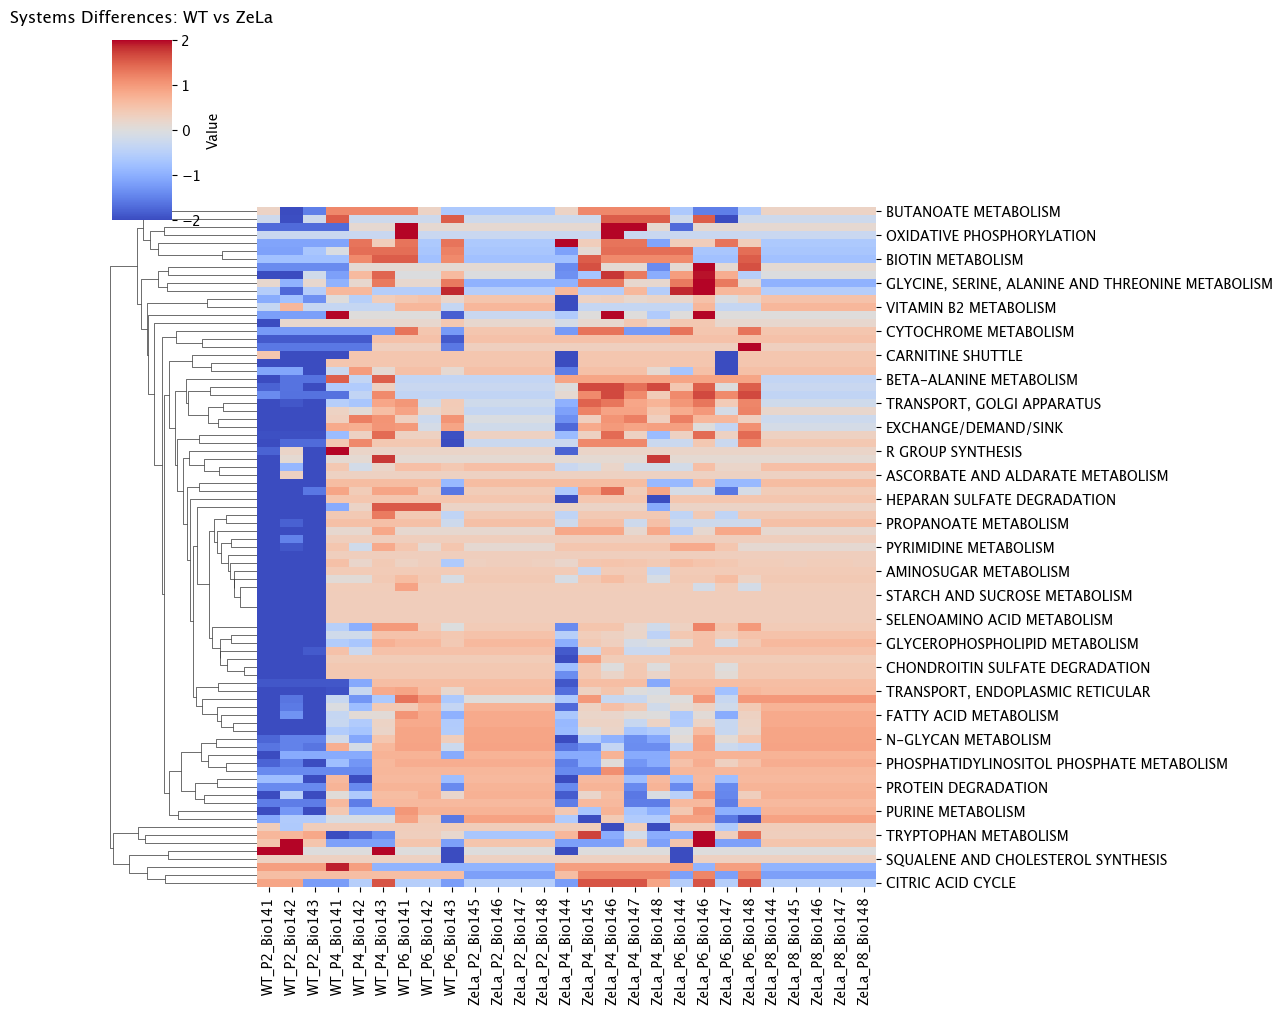


Comparing model structures


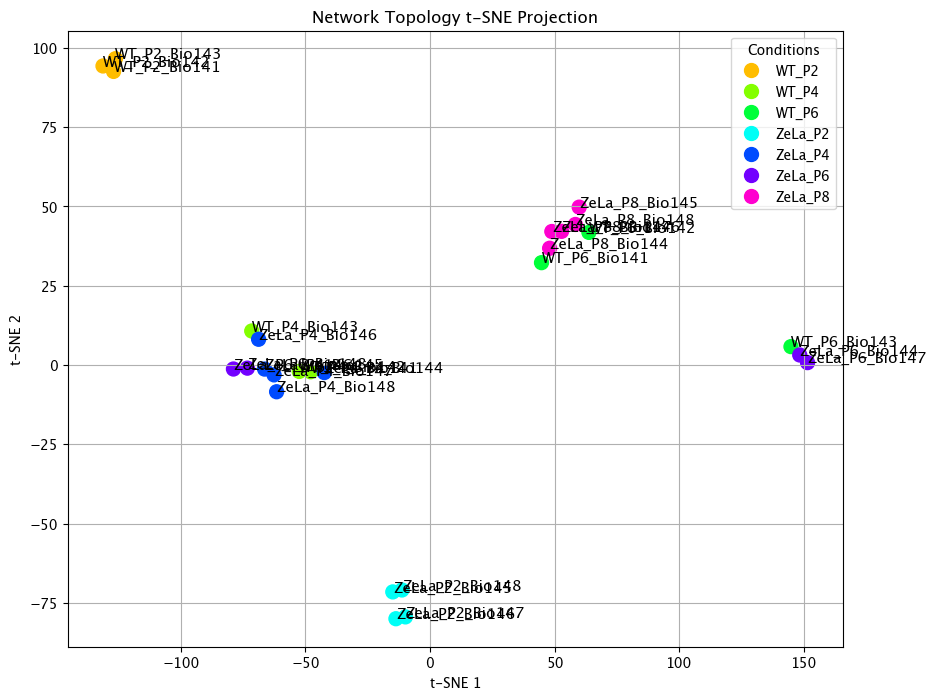

In [6]:
# Call the comparison function
save_path='../Analyses/tSNE/'

comp_struct = compare_multiple_cobra_models(
    models_list,
    print_results=False,
    plot_results=True,
    #subsystem_mapping=subsystems_dict,
    #subsystem_filter=amino_acid_subsystems,
    #condition_filter=selected_conditions,
    save_path=save_path,
    cluster_rows=True,
    cluster_cols=False
)

### Comparison of transcriptomics datasets

In [7]:
rna_seq = pd.read_csv('../Data/ZeLa Data/20200307_Bio141-148_merged.tpm.tsv', sep='\t')

In [8]:
# Create the mapping from 'S' numbers to sample conditions
sample_conditions = {
    'S1':  'WT_P2_Bio141', 'S7':  'WT_P2_Bio142', 'S13': 'WT_P2_Bio143', 'S2':  'WT_P4_Bio141', 'S8':  'WT_P4_Bio142', 'S14': 'WT_P4_Bio143', 'S3':  'WT_P6_Bio141',
    'S9':  'WT_P6_Bio142', 'S15': 'WT_P6_Bio143', 'S4':  'WT_P8_Bio141', 'S10': 'WT_P8_Bio142', 'S16': 'WT_P8_Bio143', 'S5':  'WT_P12_Bio141', 'S11': 'WT_P12_Bio142',
    'S6':  'WT_P14_Bio141', 'S12': 'WT_P14_Bio142', 'S17': 'WT_P14_Bio143', 'S18': 'ZeLa_P4_Bio144', 'S23': 'ZeLa_P4_Bio145', 'S28': 'ZeLa_P4_Bio146',
    'S34': 'ZeLa_P4_Bio147', 'S39': 'ZeLa_P4_Bio148', 'S19': 'ZeLa_P6_Bio144', 'S29': 'ZeLa_P6_Bio146', 'S35': 'ZeLa_P6_Bio147', 'S40': 'ZeLa_P6_Bio148',
    'S20': 'ZeLa_P8_Bio144', 'S24': 'ZeLa_P8_Bio145', 'S30': 'ZeLa_P8_Bio146', 'S36': 'ZeLa_P8_Bio147', 'S41': 'ZeLa_P8_Bio148', 'S25': 'ZeLa_P12_Bio145',
    'S31': 'ZeLa_P12_Bio146', 'S42': 'ZeLa_P12_Bio148', 'S21': 'ZeLa_P14_Bio144', 'S26': 'ZeLa_P14_Bio145', 'S32': 'ZeLa_P14_Bio146', 'S37': 'ZeLa_P14_Bio147',
    'S43': 'ZeLa_P14_Bio148', 'S22': 'ZeLa_P2_Bio145',  'S27': 'ZeLa_P2_Bio146', 'S33': 'ZeLa_P2_Bio147', 'S38': 'ZeLa_P2_Bio148'
}

In [9]:
# Map the columns in 'rna_seq' to sample conditions
sample_columns = rna_seq.columns.tolist()[1:]  # Exclude 'Gene' column
column_to_condition = {col: sample_conditions.get(col, 'Unknown') for col in sample_columns}

In [10]:
# Define the conditions to include
include_conditions = set(wt_model_names + zela_model_names)

# Create a list of columns to include
columns_to_include = ['Gene'] + [col for col in sample_columns if column_to_condition[col] in include_conditions]

# Subset the data
rna_seq_subset = rna_seq[columns_to_include]

In [11]:
# Get the sample conditions for the subset columns (excluding 'Gene')
subset_columns = rna_seq_subset.columns.tolist()[1:]
subset_sample_conditions = [column_to_condition[col] for col in subset_columns]

# Define a function to assign labels
def assign_sample_labels(sample_conditions):
    labels = []
    for condition in sample_conditions:
        if 'WT_P2' in condition:
            labels.append('WT_P2')
        elif 'WT_P4' in condition:
            labels.append('WT_P4')
        elif 'WT_P6' in condition:
            labels.append('WT_P6')
        elif 'WT_P8' in condition:
            labels.append('WT_P8')
        elif 'ZeLa_P2' in condition:
            labels.append('ZeLa_P2')
        elif 'ZeLa_P4' in condition:
            labels.append('ZeLa_P4')
        elif 'ZeLa_P6' in condition:
            labels.append('ZeLa_P6')
        elif 'ZeLa_P8' in condition:
            labels.append('ZeLa_P8')
        else:
            labels.append('Unknown')
    return labels

# Assign labels
labels = assign_sample_labels(subset_sample_conditions)

# Verify the labels
print("Sample Labels:")
for sample, label in zip(subset_sample_conditions, labels):
    print(f"{sample}: {label}")

Sample Labels:
WT_P2_Bio143: WT_P2
WT_P4_Bio143: WT_P4
WT_P6_Bio143: WT_P6
ZeLa_P4_Bio144: ZeLa_P4
ZeLa_P6_Bio144: ZeLa_P6
WT_P2_Bio141: WT_P2
ZeLa_P8_Bio144: ZeLa_P8
ZeLa_P2_Bio145: ZeLa_P2
ZeLa_P4_Bio145: ZeLa_P4
ZeLa_P8_Bio145: ZeLa_P8
ZeLa_P2_Bio146: ZeLa_P2
ZeLa_P4_Bio146: ZeLa_P4
ZeLa_P6_Bio146: ZeLa_P6
WT_P4_Bio141: WT_P4
ZeLa_P8_Bio146: ZeLa_P8
ZeLa_P2_Bio147: ZeLa_P2
ZeLa_P4_Bio147: ZeLa_P4
ZeLa_P6_Bio147: ZeLa_P6
ZeLa_P8_Bio147: ZeLa_P8
ZeLa_P2_Bio148: ZeLa_P2
ZeLa_P4_Bio148: ZeLa_P4
WT_P6_Bio141: WT_P6
ZeLa_P6_Bio148: ZeLa_P6
ZeLa_P8_Bio148: ZeLa_P8
WT_P2_Bio142: WT_P2
WT_P4_Bio142: WT_P4
WT_P6_Bio142: WT_P6


In [12]:
# Set 'Gene' as the index
rna_seq_subset.set_index('Gene', inplace=True)

# Perform log2 transformation
data_log = np.log2(rna_seq_subset + 1)

# Transpose the data to have samples as rows
data_matrix = data_log.T.values  # Shape: (samples, genes)

# Check for NaNs or infinite values
if np.isnan(data_matrix).any():
    print("Data contains NaNs, handling missing values.")
    # Fill NaNs with the mean expression of each gene
    data_matrix = np.nan_to_num(data_matrix, nan=np.nanmean(data_matrix))

In [13]:
# Determine perplexity
n_samples = data_matrix.shape[0]
perplexity = min(n_samples - 1, 30)

# Perform t-SNE
tsne = TSNE(metric='euclidean', n_components=3, perplexity=perplexity, random_state=42)
tsne_results = tsne.fit_transform(data_matrix)

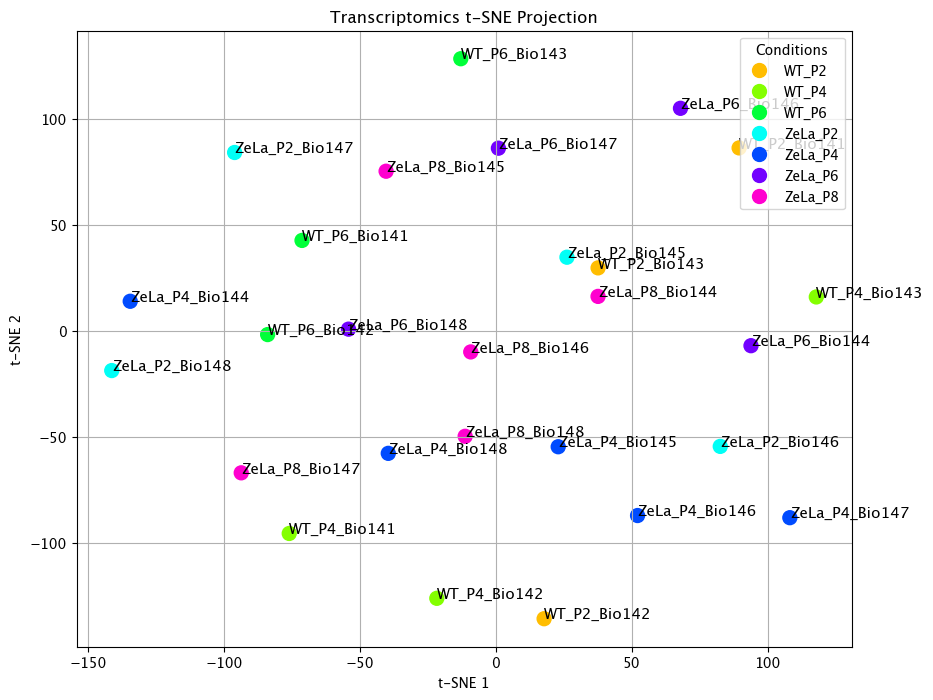

In [14]:
def plot_tsne_transcriptomics(tsne_results, labels, sample_names, title="Transcriptomics t-SNE Projection", save_path=None):
    unique_conditions = sorted(set(labels))
    color_palette = sns.color_palette("hsv", len(unique_conditions))
    condition_to_color = {condition: color_palette[i] for i, condition in enumerate(unique_conditions)}
    colors = [condition_to_color[label] for label in labels]
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors, s=100)
    for i, sample_name in enumerate(sample_names):
        plt.annotate(sample_name, (tsne_results[i, 0], tsne_results[i, 1]), fontsize=11)
    handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=10)
               for condition, color in condition_to_color.items()]
    plt.legend(handles, unique_conditions, title="Conditions", loc="best")
    plt.title(title)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.grid(True)

    # Save the plot if save_path is provided
    if save_path:
        # Ensure the directory exists
        os.makedirs(save_path, exist_ok=True)

        # Replace spaces and special characters in the title to create a valid filename
        sanitized_title = title.replace(' ', '_').replace('-', '_').replace(':', '_')

        # Construct the full file path with the .svg extension
        filename = f"{sanitized_title}.svg"
        full_path = os.path.join(save_path, filename)

        plt.savefig(full_path, format='svg', bbox_inches='tight')
    
    plt.show()

# Call the plotting function
save_path='../Analyses/tSNE/'
sample_names = subset_sample_conditions  # Sample conditions corresponding to the samples
plot_tsne_transcriptomics(tsne_results, labels, sample_names, save_path=save_path)

## 4. Biomass prediction using exp. data <a id='biomass'></a>

In [ ]:
import os
import math
import pickle
import pandas as pd

import cobra
from cobra import Reaction
from cobra.io import load_json_model, read_sbml_model, load_matlab_model
from cobra.exceptions import Infeasible
from cobra.sampling import ACHRSampler

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

### Mode and Data Loading

In [ ]:
# Directory containing context-specific models models
model_directory = '../Data/Context_specific_models/'

# Model Names
wt_model_names = ['WT_P2_Bio141', 'WT_P2_Bio142', 'WT_P2_Bio143',
                  'WT_P4_Bio141', 'WT_P4_Bio142', 'WT_P4_Bio143',
                  'WT_P6_Bio141', 'WT_P6_Bio142', 'WT_P6_Bio143']

zela_model_names = ['ZeLa_P2_Bio145', 'ZeLa_P2_Bio146', 'ZeLa_P2_Bio147', 'ZeLa_P2_Bio148',
                    'ZeLa_P4_Bio144', 'ZeLa_P4_Bio145', 'ZeLa_P4_Bio146', 'ZeLa_P4_Bio147', 'ZeLa_P4_Bio148',
                    'ZeLa_P6_Bio144', 'ZeLa_P6_Bio146', 'ZeLa_P6_Bio147', 'ZeLa_P6_Bio148',
                    'ZeLa_P8_Bio144', 'ZeLa_P8_Bio145', 'ZeLa_P8_Bio146', 'ZeLa_P8_Bio147', 'ZeLa_P8_Bio148']

# Dictionaries to store the loaded models
wt_models = {}
zela_models = {}

# List all .mat files in the directory
model_files = [f for f in os.listdir(model_directory) if f.endswith('.mat')]

# Iterate through the .mat files and load only the models that match predefined strings
for model_file in model_files:
    # Full path to the model file
    model_path = os.path.join(model_directory, model_file)
    
    # Check if the file corresponds to a WT model
    for model_name in wt_model_names:
        if model_name in model_file:
            wt_models[model_name] = load_matlab_model(model_path)
            wt_models[model_name].id = model_name
            print(f"Loaded WT model: {model_name}")
            break  # Stop checking other names since this file is already processed
    
    # Check if the file corresponds to a ZeLa model
    for model_name in zela_model_names:
        if model_name in model_file:
            zela_models[model_name] = load_matlab_model(model_path)
            zela_models[model_name].id = model_name
            print(f"Loaded ZeLa model: {model_name}")
            break  # Stop checking other names since this file is already processed

In [ ]:
# Load uptake and secretion rate dict

with open('../Data/Uptake_Secretion_Rates/uptake_secretion_raw_wt_dict.pkl', 'rb') as file:
    uptsec_wt = pickle.load(file)

with open('../Data/Uptake_Secretion_Rates/uptake_secretion_raw_zela_dict.pkl', 'rb') as file:
    uptsec_zela = pickle.load(file)

### Pre-processing

In [ ]:
# ATP generating reactions loop

atp_loop_reactions = [
 'SCP22x','TMNDNCCOAtx','OCCOAtx','r0391','BiGGRxn67','r2247','r2246','r2245','r2317','HMR_0293',
 'HMR_7741','r1453','r1393','NICRNS','GapFill-R08726','RE2915M','HMR_3288','HMR_1325','RE2439C',
 'r1450','RE3477C','AAPSAS','r0698','3HDH260p','HMR_3272','ACOAD183n3m','GapFill-R01463','r1468',
 'r0655','r0603','r0541','HMR_1329','GapFill-R03599','AKGDm','r0556','OIVD1m','OIVD3m','2OXOADOXm',
 'r0386','r0451','GLYCLm','MACACI'
]

In [ ]:
# Sanity Check. Make sure all the exchange reactions in the experimental data are present in the model and that the models ar growing

for name,model in zela_models.items():
    print('---------------------------------------')
    print(f'------------{model.id}------------')
    print('')
    print(f'Objective:{model.objective}')
    print('')
    print(f'GR1: {model.slim_optimize()}')
    exchanges = list(uptsec_wt.keys())
    
    model_ex = [r.id for r in model.boundary]
    model_reactions = [r.id for r in model.reactions]

    # Remove ATP loop reactions
    for atp_reaction in atp_loop_reactions:
        if atp_reaction in model_reactions:
            # Knock out the reaction temporarily
            reaction = model.reactions.get_by_id(atp_reaction)
            original_bounds = reaction.bounds  # Store the original bounds to revert later
            reaction.knock_out()
            
            # Test if the model remains feasible after knocking out the reaction
            new_gr = model.slim_optimize()
            print(f'GR2 (After knocking out {atp_reaction}): {new_gr}')
            
            # Check if the model's growth rate is infeasible or close to zero
            if math.isnan(new_gr) or new_gr < 1e-6:
                print(f'{atp_reaction} causes infeasibility. Reverting knockout.')
                reaction.bounds = (0,1000)  # Set reaction to irreversible

                new_gr_3 = model.slim_optimize() # Optimize model with irreversible reaction
                print(f'GR3 (After making reaction irreversible {atp_reaction}): {new_gr_3}')

                # Check if the model's growth rate 3 is infeasible or close to zero
                if math.isnan(new_gr_3) or new_gr_3 < 1e-6:
                    print(f'{atp_reaction} in its irreversible format causes infeasibility.')
                    reaction.bounds = original_bounds
                else:
                    print(f'{atp_reaction} successfully transformed to reversible without infeasibility.')
                    
            else:
                print(f'{atp_reaction} successfully knocked out without infeasibility.')

                
    print('')
    print('Missing reactions from exp data:')
    for ex in exchanges:
        if ex not in model_ex:
            print(ex)
    print('---------------------------------------')
    print('---------------------------------------')
    print('')
    print('')


for name,model in wt_models.items():
    print('---------------------------------------')
    print(f'------------{model.id}------------')
    print('')
    print(f'Objective:{model.objective}')
    print('---------------------------------------')
    print(f'GR: {model.slim_optimize()}')
    exchanges = list(uptsec_wt.keys())
    model_ex = [r.id for r in model.boundary]
    model_reactions = [r.id for r in model.reactions]

    # Remove ATP loop reactions
    for atp_reaction in atp_loop_reactions:
        if atp_reaction in model_reactions:
            # Knock out the reaction temporarily
            reaction = model.reactions.get_by_id(atp_reaction)
            original_bounds = reaction.bounds  # Store the original bounds to revert later
            reaction.knock_out()
            
            # Test if the model remains feasible after knocking out the reaction
            new_gr = model.slim_optimize()
            print(f'GR2 (After knocking out {atp_reaction}): {new_gr}')
            
            # Check if the model's growth rate is infeasible or close to zero
            if math.isnan(new_gr) or new_gr < 1e-6:
                print(f'{atp_reaction} causes infeasibility. Reverting knockout.')
                reaction.bounds = (0,1000)  # Set reaction to irreversible

                new_gr_3 = model.slim_optimize() # Optimize model with irreversible reaction
                print(f'GR3 (After making reaction irreversible {atp_reaction}): {new_gr_3}')

                # Check if the model's growth rate 3 is infeasible or close to zero
                if math.isnan(new_gr_3) or new_gr_3 < 1e-6:
                    print(f'{atp_reaction} in its irreversible format causes infeasibility.')
                    reaction.bounds = original_bounds
                else:
                    print(f'{atp_reaction} successfully transformed to reversible without infeasibility.')
                    
            else:
                print(f'{atp_reaction} successfully knocked out without infeasibility.')
    
    for ex in exchanges:
        if ex not in model_ex:
            print(ex)
    print('---------------------------------------')
    print('---------------------------------------')
    print('')

### Growth Rate Predictions

In [ ]:
pfba_solutions_fluxes = []

In [ ]:
# WT

results = []

objective = 'biomass_cho_s'

# Adjust the lower bound values according to the experimental growth rates in order to indetify bottlenecks
intervals = {'P0 to P2':'P2', 'P2 to P4':'P4', 'P4 to P6':'P6', 'P6 to P8':'P8', 'P8 to P12':'P12', 'P12 to P14':'P14'}
replicates = {'U1':'Bio141', 'U2':'Bio142', 'U3':'Bio143'}

for name,model in wt_models.items():
    print(f"Processing model: {name}")
    # Set lower bounds of the reactions according to the experimental data
    for interval_key, interval_model_time in intervals.items():
        if interval_model_time in name:  # Match model name with interval
            for rep_key, rep_suffix in replicates.items():
                if rep_suffix in name:  # Match replicate with model name

                     with model as modified_model:

                        # Open the bounds for the biomass reaction 
                        modified_model.reactions.biomass_cho_s.bounds = (0,1000)
                         
                        # Create a copy of the modified_model before making changes
                        pre_modification_model = modified_model.copy()
                         
                        for rxn in modified_model.boundary:
                            # Keep boundaries open for essential metabolites
                            if rxn.id in ['EX_h2o_e', 'EX_h_e', 'EX_o2_e', 'EX_hco3_e', 'EX_so4_e', 'EX_pi_e']:
                                rxn.bounds = (-1000, 1000)
                            elif rxn.id in ['SK_Asn_X_Ser_Thr_r', 'SK_Tyr_ggn_c', 'SK_Ser_Thr_g', 'SK_pre_prot_r']:
                                rxn.bounds = (-0.001, 1000)
                            elif rxn.id.startswith(("EX_", "SK_", "DM_")):
                                rxn.bounds = (0, 1000)  # Close uptake rates for others
                        
                        print(f'Calculating Growth Rate for WT Condition:{rep_key,interval_key}')
                        exp_gr = uptsec_wt['exp_growth_rate'][(rep_key,interval_key)]
                        print(f'Experimental growth rate is: {exp_gr}')
                        for reaction in modified_model.reactions:
                            if reaction.id == 'EX_etoh_e': #Model creates infeasible solutions when secreting etoh
                                continue
                            elif reaction.id == 'ATPM': # Add ATP Maintenance Cost
                                reaction.lower_bound = 0
                            for r,v in uptsec_wt.items():
                                if reaction.id == r:
                                    reaction.upper_bound = 1000
                                    reaction.lower_bound = v[(rep_key,interval_key)]
                                    
                        try:                            
                            pfba_solution = cobra.flux_analysis.pfba(modified_model)
                            pfba_obj = pfba_solution.fluxes[objective]
                            pfba_atp = pfba_solution.fluxes['ATPM']
                            print(f'Simulated ATP Maintencance is: {pfba_atp}')
                            print(f'Simulated growth rate is: {pfba_obj}')
            
                            # If pFBA succeeds, proceed to sampling
                            pfba_model_to_sample = modified_model
                            
                        except Infeasible:
                            print(f'Infeasible solution for replicate {rep_key} interval {interval_key}')
                            print('Reverting to the original model and retrying pFBA...')
                            '''
                            for rxn in pre_modification_model.boundary:
                            # Keep boundaries open for essential metabolites
                                if rxn.id in ['EX_h2o_e', 'EX_h_e', 'EX_o2_e', 'EX_hco3_e', 'EX_so4_e', 'EX_pi_e']:
                                    rxn.bounds = (-1000, 1000)
                                elif rxn.id in ['SK_Asn_X_Ser_Thr_r', 'SK_Tyr_ggn_c', 'SK_Ser_Thr_g', 'SK_pre_prot_r']:
                                    rxn.bounds = (-0.001, 1000)
                            '''
                            pfba_solution = cobra.flux_analysis.pfba(pre_modification_model)
                            pfba_obj = pfba_solution.fluxes[objective]
                            pfba_atp = pfba_solution.fluxes['ATPM']
                            print(f'Simulated ATP Maintencance is: {pfba_atp}')
                            print(f'Simulated growth rate with original model is: {pfba_obj}')

                            # If pFBA with original model succeeds, proceed to sampling
                            pfba_model_to_sample = pre_modification_model

                        results.append([rep_suffix, interval_key, exp_gr, pfba_obj])
                        # Save the solution with metadata
                        pfba_solutions_fluxes.append({
                            "model": pre_modification_model.id,
                            "condition": interval_key,
                            "fluxes": pfba_solution.fluxes
                        })

                        
# Creating a DataFrame
df_wt = pd.DataFrame(results, columns=['Hue', 'Category', 'X Axis', 'Y Axis'])

In [ ]:
df =df_wt
# Define markers for categories
markers = {
    'P0 to P2': 'p',  # Circle
    'P2 to P4': 'o',  # Circle
    'P4 to P6': 's',   # Square
}

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot each group with different colors for hue and different shapes for categories
hues = df['Hue'].unique()
colors = plt.colormaps.get_cmap('tab10')

for hue_idx, hue in enumerate(hues):
    hue_subset = df[df['Hue'] == hue]
    for category, marker in markers.items():
        subset = hue_subset[hue_subset['Category'] == category]
        plt.scatter(subset['X Axis'], subset['Y Axis'], label=f'{hue} - {category}', marker=marker, s=100, color=colors(hue_idx))

# Add the identity line y = x
plt.plot([0.00, 0.055], [0.00, 0.055], color='red', linestyle='--')

# Set evenly distributed ticks from 0.01 to 0.08
ticks = [i / 100.0 for i in range(1, 11)]
plt.xticks(ticks=ticks, labels=[f'{i/100.0:.2f}' for i in range(1, 11)])
plt.yticks(ticks=ticks, labels=[f'{i/100.0:.2f}' for i in range(1, 11)])

# Set limits for both axes
plt.xlim(0.0, 0.055)
plt.ylim(0.0, 0.055)

# Setting the same scale for both axes
plt.gca().set_aspect('equal', adjustable='box')

# Adding labels and title
plt.xlabel('Experimental Growth Rate')
plt.ylabel('Simulated Growth Rate')
plt.title('WT')
plt.legend(title='Hue - Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.savefig('../Analyses/growth_rate_pred/bar_plot_growth_rate_wt.png')
plt.show()

In [ ]:
# ZeLa

results = []

objective = 'biomass_cho_s'

# Adjust the lower bound values according to the experimental growth rates in order to indetify bottlenecks
intervals = {'P0 to P2':'P2', 'P2 to P4':'P4', 'P4 to P6':'P6', 'P6 to P8':'P8', 'P8 to P12':'P12', 'P12 to P14':'P14'}
replicates = {'U4':'Bio144', 'U5':'Bio145', 'U6':'Bio146', 'U7':'Bio147', 'U8':'Bio148'}

for name,model in zela_models.items():
    print(f"Processing model: {name}")
    # Set lower bounds of the reactions according to the experimental data
    for interval_key, interval_model_time in intervals.items():
        if interval_model_time in name:  # Match model name with interval
            for rep_key, rep_suffix in replicates.items():
                if rep_suffix in name:  # Match replicate with model name
                    
                     with model as modified_model:

                        # Open the bounds for the biomass reaction 
                        modified_model.reactions.biomass_cho_s.bounds = (0,1000)
                         
                        # Create a copy of the modified_model before making changes
                        pre_modification_model = modified_model.copy()
 
                        for rxn in modified_model.boundary:
                            if rxn.id in ['EX_h2o_e', 'EX_h_e', 'EX_o2_e', 'EX_hco3_e', 'EX_so4_e', 'EX_pi_e']:
                                rxn.bounds = (-1000, 1000)
                            elif rxn.id in ['SK_Asn_X_Ser_Thr_r', 'SK_Tyr_ggn_c', 'SK_Ser_Thr_g', 'SK_pre_prot_r']:
                                rxn.bounds = (-0.001, 1000)
                            elif rxn.id.startswith(("EX_", "SK_", "DM_")):
                                rxn.bounds = (0, 1000)  # Close uptake rates for others

                        print(f'Calculating Growth Rate for ZeLa Condition:{rep_key,interval_key}')
                        exp_gr = uptsec_zela['exp_growth_rate'][(rep_key,interval_key)]
                        print(f'Experimental growth rate is: {exp_gr}')
                        for reaction in modified_model.reactions:
                            if reaction.id == 'EX_etoh_e': #Model creates infeasible solutions when secreting etoh
                                continue
                            elif reaction.id == 'ATPM': # Add ATP Maintenance Cost
                                reaction.lower_bound = 6
                            for r,v in uptsec_zela.items():
                                if reaction.id == r:
                                    reaction.upper_bound = 1000
                                    reaction.lower_bound = v[(rep_key,interval_key)]
                                    
                        try:                         
                            pfba_solution = cobra.flux_analysis.pfba(modified_model)
                            pfba_obj = pfba_solution.fluxes[objective]
                            pfba_atp = pfba_solution.fluxes['ATPM']
                            print(f'Simulated ATP Maintencance is: {pfba_atp}')
                            print(f'Simulated growth rate is: {pfba_obj}')
                            
                        except Infeasible:
                            print(f'Infeasible solution for replicate {rep_key} interval {interval_key}')
                            print('Reverting to the original model and retrying pFBA...')

                            for rxn in pre_modification_model.reactions:
                                if rxn.id in ['EX_h2o_e', 'EX_h_e', 'EX_o2_e', 'EX_hco3_e', 'EX_so4_e', 'EX_pi_e']:
                                    rxn.bounds = (-1000, 1000)
                                elif rxn.id in ['SK_Asn_X_Ser_Thr_r', 'SK_Tyr_ggn_c', 'SK_Ser_Thr_g', 'SK_pre_prot_r']:
                                    rxn.bounds = (-0.001, 1000)
                                elif rxn.id == 'ATPM': # Add ATP Maintenance Cost
                                    rxn.lower_bound = 0
                                  
                            pfba_solution = cobra.flux_analysis.pfba(pre_modification_model)
                            pfba_obj = pfba_solution.fluxes[objective]
                            pfba_atp = pfba_solution.fluxes['ATPM']
                            print(f'Simulated ATP Maintencance is: {pfba_atp}')
                            print(f'Simulated growth rate with original model is: {pfba_obj}')
                            
                        results.append([rep_suffix, interval_key, exp_gr, pfba_obj])

                        # Save the solution with metadata
                        pfba_solutions_fluxes.append({
                            "model": pre_modification_model.id,
                            "condition": interval_key,
                            "fluxes": pfba_solution.fluxes
                        })
                        
# Creating a DataFrame
df_zela = pd.DataFrame(results, columns=['Hue', 'Category', 'X Axis', 'Y Axis'])

In [ ]:
df =df_zela
# Define markers for categories
markers = {
    'P0 to P2': 'p',
    'P2 to P4': 'o',  # Circle
    'P4 to P6': 's',   # Square
    'P6 to P8': 'v',
}

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot each group with different colors for hue and different shapes for categories
hues = df['Hue'].unique()
colors = plt.colormaps.get_cmap('tab10')

for hue_idx, hue in enumerate(hues):
    hue_subset = df[df['Hue'] == hue]
    for category, marker in markers.items():
        subset = hue_subset[hue_subset['Category'] == category]
        plt.scatter(subset['X Axis'], subset['Y Axis'], label=f'{hue} - {category}', marker=marker, s=100, color=colors(hue_idx))

# Add the identity line y = x
plt.plot([0.00, 0.055], [0.00, 0.055], color='red', linestyle='--')

# Set evenly distributed ticks from 0.01 to 0.08
ticks = [i / 100.0 for i in range(1,11)]
plt.xticks(ticks=ticks, labels=[f'{i/100.0:.2f}' for i in range(1, 11)])
plt.yticks(ticks=ticks, labels=[f'{i/100.0:.2f}' for i in range(1, 11)])

# Set limits for both axes
plt.xlim(0.0, 0.055)
plt.ylim(0.0, 0.055)

# Setting the same scale for both axes
plt.gca().set_aspect('equal', adjustable='box')

# Adding labels and title
plt.xlabel('Experimental Growth Rate')
plt.ylabel('Simulated Growth Rate')
plt.title('ZeLa')
plt.legend(title='Hue - Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.savefig('../Analyses/growth_rate_pred/bar_plot_growth_rate_zela.png')
plt.show()

In [ ]:
for reaction, values in uptsec_zela.items():
    plt.figure(figsize=(10, 6))
    
    # Organize data for plotting
    batches = sorted(set(k[0] for k in values.keys()))
    timepoints = ['P0 to P2', 'P2 to P4', 'P4 to P6', 'P6 to P8', 'P8 to P12', 'P12 to P14']
    
    for batch in batches:
        batch_data = [values.get((batch, tp), 0) for tp in timepoints]
        plt.plot(timepoints, batch_data, marker='o', label=batch)
    
    plt.title(f'Changes in {reaction} over time')
    plt.xlabel('Timepoints')
    plt.ylabel('Values')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

In [ ]:
for reaction, values in uptsec_wt.items():
    plt.figure(figsize=(10, 6))
    
    # Organize data for plotting
    batches = sorted(set(k[0] for k in values.keys()))
    timepoints = ['P0 to P2', 'P2 to P4', 'P4 to P6', 'P6 to P8', 'P8 to P12', 'P12 to P14']
    
    for batch in batches:
        batch_data = [values.get((batch, tp), 0) for tp in timepoints]
        plt.plot(timepoints, batch_data, marker='o', label=batch)
    
    plt.title(f'Changes in {reaction} over time')
    plt.xlabel('Timepoints')
    plt.ylabel('Values')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

## 5. Flux Sampling Analysis <a id='fsa'></a>

In [ ]:
import os
import math
import pickle
import pandas as pd

import cobra
from cobra import Reaction
from cobra.io import load_json_model, read_sbml_model, load_matlab_model
from cobra.flux_analysis.loopless import add_loopless
from cobra.exceptions import Infeasible
from cobra.sampling import ACHRSampler

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

### Model and Data Loading

In [ ]:
# Directory containing context-specific models models
model_directory = '../Data/Context_specific_models/'

# Model Names
wt_model_names = ['WT_P4_Bio141', 'WT_P4_Bio142', 'WT_P4_Bio143',
                  'WT_P6_Bio141', 'WT_P6_Bio142', 'WT_P6_Bio143']

zela_model_names = ['ZeLa_P4_Bio144', 'ZeLa_P4_Bio145', 'ZeLa_P4_Bio146', 'ZeLa_P4_Bio147', 'ZeLa_P4_Bio148',
                    'ZeLa_P6_Bio144', 'ZeLa_P6_Bio146', 'ZeLa_P6_Bio147', 'ZeLa_P6_Bio148']

# Dictionaries to store the loaded models
wt_models = {}
zela_models = {}

# List all .mat files in the directory
model_files = [f for f in os.listdir(model_directory) if f.endswith('.mat')]

# Iterate through the .mat files and load only the models that match predefined strings
for model_file in model_files:
    # Full path to the model file
    model_path = os.path.join(model_directory, model_file)
    
    # Check if the file corresponds to a WT model
    for model_name in wt_model_names:
        if model_name in model_file:
            wt_models[model_name] = load_matlab_model(model_path)
            wt_models[model_name].id = model_name
            print(f"Loaded WT model: {model_name}")
            break  # Stop checking other names since this file is already processed
    
    # Check if the file corresponds to a ZeLa model
    for model_name in zela_model_names:
        if model_name in model_file:
            zela_models[model_name] = load_matlab_model(model_path)
            zela_models[model_name].id = model_name
            print(f"Loaded ZeLa model: {model_name}")
            break  # Stop checking other names since this file is already processed

In [ ]:
# Load uptake and secretion rate dict

with open('../Data/Uptake_Secretion_Rates/uptake_secretion_raw_wt_dict.pkl', 'rb') as file:
    uptsec_wt = pickle.load(file)

with open('../Data/Uptake_Secretion_Rates/uptake_secretion_raw_zela_dict.pkl', 'rb') as file:
    uptsec_zela = pickle.load(file)

### Pre-processing

In [ ]:
# ATP generating reactions loop

atp_loop_reactions = [
 'SCP22x','TMNDNCCOAtx','OCCOAtx','r0391','BiGGRxn67','r2247','r2246','r2245','r2317','HMR_0293',
 'HMR_7741','r1453','r1393','NICRNS','GapFill-R08726','RE2915M','HMR_3288','HMR_1325','RE2439C',
 'r1450','RE3477C','AAPSAS','r0698','3HDH260p','HMR_3272','ACOAD183n3m','GapFill-R01463','r1468',
 'r0655','r0603','r0541','HMR_1329','GapFill-R03599','AKGDm','r0556','OIVD1m','OIVD3m','2OXOADOXm',
 'r0386','r0451','GLYCLm','MACACI'
]

In [ ]:
# Sanity Check. Make sure all the exchange reactions in the experimental data are present in the model and that the models ar growing

for name,model in zela_models.items():
    print('---------------------------------------')
    print(f'------------{model.id}------------')
    print('')
    print(f'Objective:{model.objective}')
    print('')
    print(f'GR1: {model.slim_optimize()}')
    exchanges = list(uptsec_wt.keys())
    
    model_ex = [r.id for r in model.boundary]
    model_reactions = [r.id for r in model.reactions]

    # Remove ATP loop reactions
    for atp_reaction in atp_loop_reactions:
        if atp_reaction in model_reactions:
            # Knock out the reaction temporarily
            reaction = model.reactions.get_by_id(atp_reaction)
            original_bounds = reaction.bounds  # Store the original bounds to revert later
            reaction.knock_out()
            
            # Test if the model remains feasible after knocking out the reaction
            new_gr = model.slim_optimize()
            print(f'GR2 (After knocking out {atp_reaction}): {new_gr}')
            
            # Check if the model's growth rate is infeasible or close to zero
            if math.isnan(new_gr) or new_gr < 1e-6:
                print(f'{atp_reaction} causes infeasibility. Reverting knockout.')
                reaction.bounds = (0,1000)  # Set reaction to irreversible

                new_gr_3 = model.slim_optimize() # Optimize model with irreversible reaction
                print(f'GR3 (After making reaction irreversible {atp_reaction}): {new_gr_3}')

                # Check if the model's growth rate 3 is infeasible or close to zero
                if math.isnan(new_gr_3) or new_gr_3 < 1e-6:
                    print(f'{atp_reaction} in its irreversible format causes infeasibility.')
                    reaction.bounds = original_bounds
                else:
                    print(f'{atp_reaction} successfully transformed to reversible without infeasibility.')
                    
            else:
                print(f'{atp_reaction} successfully knocked out without infeasibility.')

                
    print('')
    print('Missing reactions from exp data:')
    for ex in exchanges:
        if ex not in model_ex:
            print(ex)
    print('---------------------------------------')
    print('---------------------------------------')
    print('')
    print('')


for name,model in wt_models.items():
    print('---------------------------------------')
    print(f'------------{model.id}------------')
    print('')
    print(f'Objective:{model.objective}')
    print('---------------------------------------')
    print(f'GR: {model.slim_optimize()}')
    exchanges = list(uptsec_wt.keys())
    model_ex = [r.id for r in model.boundary]
    model_reactions = [r.id for r in model.reactions]

    # Remove ATP loop reactions
    for atp_reaction in atp_loop_reactions:
        if atp_reaction in model_reactions:
            # Knock out the reaction temporarily
            reaction = model.reactions.get_by_id(atp_reaction)
            original_bounds = reaction.bounds  # Store the original bounds to revert later
            reaction.knock_out()
            
            # Test if the model remains feasible after knocking out the reaction
            new_gr = model.slim_optimize()
            print(f'GR2 (After knocking out {atp_reaction}): {new_gr}')
            
            # Check if the model's growth rate is infeasible or close to zero
            if math.isnan(new_gr) or new_gr < 1e-6:
                print(f'{atp_reaction} causes infeasibility. Reverting knockout.')
                reaction.bounds = (0,1000)  # Set reaction to irreversible

                new_gr_3 = model.slim_optimize() # Optimize model with irreversible reaction
                print(f'GR3 (After making reaction irreversible {atp_reaction}): {new_gr_3}')

                # Check if the model's growth rate 3 is infeasible or close to zero
                if math.isnan(new_gr_3) or new_gr_3 < 1e-6:
                    print(f'{atp_reaction} in its irreversible format causes infeasibility.')
                    reaction.bounds = original_bounds
                else:
                    print(f'{atp_reaction} successfully transformed to reversible without infeasibility.')
                    
            else:
                print(f'{atp_reaction} successfully knocked out without infeasibility.')
    
    for ex in exchanges:
        if ex not in model_ex:
            print(ex)
    print('---------------------------------------')
    print('---------------------------------------')
    print('')

### Flux Sampling Simulations

In [ ]:
# WT

objective = 'biomass_cho_s'

# Adjust the lower bound values according to the experimental growth rates in order to indetify bottlenecks
intervals = {'P2 to P4':'P4', 'P4 to P6':'P6'}
replicates = {'U1':'Bio141', 'U2':'Bio142', 'U3':'Bio143'}

for name,model in wt_models.items():
    print(f"Processing model: {name}")
    # Set lower bounds of the reactions according to the experimental data
    for interval_key, interval_model_time in intervals.items():
        if interval_model_time in name:  # Match model name with interval
            for rep_key, rep_suffix in replicates.items():
                if rep_suffix in name:  # Match replicate with model name

                     with model as modified_model:
                         
                        for rxn in modified_model.boundary:
                            # Keep boundaries open for essential metabolites
                            if rxn.id in ['EX_h2o_e', 'EX_h_e', 'EX_o2_e', 'EX_hco3_e', 'EX_so4_e', 'EX_pi_e']:
                                rxn.bounds = (-1000, 1000)
                            elif rxn.id in ['SK_Asn_X_Ser_Thr_r', 'SK_Tyr_ggn_c', 'SK_Ser_Thr_g', 'SK_pre_prot_r']:
                                rxn.bounds = (-0.001, 1000)
                            elif rxn.id.startswith(("EX_", "SK_", "DM_")):
                                rxn.bounds = (0, 1000)  # Close uptake rates for others
                        
                        print(f'Calculating Growth Rate for WT Condition:{rep_key,interval_key}')
                        exp_gr = uptsec_wt['exp_growth_rate'][(rep_key,interval_key)]
                        print(f'Experimental growth rate is: {exp_gr}')
                        for reaction in modified_model.reactions:
                            if reaction.id == 'EX_etoh_e': #Model creates infeasible solutions when secreting etoh
                                continue
                            for r,v in uptsec_wt.items():
                                if reaction.id == r:
                                    reaction.upper_bound = 1000
                                    reaction.lower_bound = v[(rep_key,interval_key)]
                                    
                        try:
                            pfba_solution = cobra.flux_analysis.pfba(modified_model)
                            pfba_obj = pfba_solution.fluxes[objective]
                            print(f'Simulated growth rate is: {pfba_obj}')
            
                            # If pFBA succeeds, proceed to sampling
                            pfba_model_to_sample = modified_model

                            # Perform flux sampling using ACHRSampler
                            print("Performing flux sampling...")
                            achr_sampler = ACHRSampler(pfba_model_to_sample)
                            samples = 10000 
                            sampled_fluxes = achr_sampler.sample(samples)
                            
                            # Validate and save the sampled fluxes
                            if 'v' not in achr_sampler.validate(sampled_fluxes).flatten():
                                print(f"Error in sampling for {rep_key}, {interval_key}")
                            else:
                                f_name = f"../Analyses/flux_sampling/Sampling_{name}_{samples}.pkl"
                                with open(f_name, 'wb') as file:
                                    pickle.dump(sampled_fluxes, file)
                            
                        except Infeasible:
                            print(f'Infeasible solution for replicate {rep_key} interval {interval_key}')

In [ ]:
# ZeLa

objective = 'biomass_cho_s'

# Adjust the lower bound values according to the experimental growth rates in order to indetify bottlenecks
intervals = {'P2 to P4':'P4', 'P4 to P6':'P6'}
replicates = {'U4':'Bio144', 'U5':'Bio145', 'U6':'Bio146', 'U7':'Bio147', 'U8':'Bio148'}

for name,model in zela_models.items():
    print(f"Processing model: {name}")
    # Set lower bounds of the reactions according to the experimental data
    for interval_key, interval_model_time in intervals.items():
        if interval_model_time in name:  # Match model name with interval
            for rep_key, rep_suffix in replicates.items():
                if rep_suffix in name:  # Match replicate with model name
                    
                     with model as modified_model:
                         
                        for rxn in modified_model.boundary:
                            # Keep boundaries open for essential metabolites
                            if rxn.id in ['EX_h2o_e', 'EX_h_e', 'EX_o2_e', 'EX_hco3_e', 'EX_so4_e', 'EX_pi_e']:
                                rxn.bounds = (-1000, 1000)
                            elif rxn.id in ['SK_Asn_X_Ser_Thr_r', 'SK_Tyr_ggn_c', 'SK_Ser_Thr_g', 'SK_pre_prot_r']:
                                rxn.bounds = (-0.001, 1000)
                            elif rxn.id.startswith(("EX_", "SK_", "DM_")):
                                rxn.bounds = (0, 1000)  # Close uptake rates for others
                        
                        print(f'Calculating Growth Rate for WT Condition:{rep_key,interval_key}')
                        exp_gr = uptsec_zela['exp_growth_rate'][(rep_key,interval_key)]
                        print(f'Experimental growth rate is: {exp_gr}')
                        for reaction in modified_model.reactions:
                            if reaction.id == 'EX_etoh_e': #Model creates infeasible solutions when secreting etoh
                                continue
                            for r,v in uptsec_zela.items():
                                if reaction.id == r:
                                    reaction.upper_bound = 1000
                                    reaction.lower_bound = v[(rep_key,interval_key)]
                                    
                        try:
                            pfba_solution = cobra.flux_analysis.pfba(modified_model)
                            pfba_obj = pfba_solution.fluxes[objective]
                            print(f'Simulated growth rate is: {pfba_obj}')
            
                            # If pFBA succeeds, proceed to sampling
                            pfba_model_to_sample = modified_model
                            
                            # Perform flux sampling using ACHRSampler
                            print("Performing flux sampling...")
                            achr_sampler = ACHRSampler(pfba_model_to_sample)
                            samples = 10000 
                            sampled_fluxes = achr_sampler.sample(samples)
                            
                            # Validate and save the sampled fluxes
                            if 'v' not in achr_sampler.validate(sampled_fluxes).flatten():
                                print(f"Error in sampling for {rep_key}, {interval_key}")
                            else:
                                f_name = f"../Analyses/flux_sampling/Sampling_{name}_{samples}.pkl"
                                with open(f_name, 'wb') as file:
                                    pickle.dump(sampled_fluxes, file)
                            
                        except Infeasible:
                            print(f'Infeasible solution for replicate {rep_key} interval {interval_key}')

In [ ]:
def adsb_sampling(model, n_samples, steps_per_point):
    current_solution = model.optimize()
    if current_solution.status != "optimal":
        raise ValueError("Initial optimization did not yield an optimal solution.")

    current_fluxes = np.array([rxn.flux for rxn in model.reactions])
    n_rxns = len(model.reactions)
    samples = []

    for _ in range(n_samples):
        direction = np.random.randn(n_rxns)
        direction /= np.linalg.norm(direction)

        step_size = random.uniform(-1, 1)  # Allow step size to be negative or positive
        proposed_fluxes = current_fluxes + step_size * direction

        for i, rxn in enumerate(model.reactions):
            rxn.lower_bound = min(proposed_fluxes[i], rxn.upper_bound)
            rxn.upper_bound = max(proposed_fluxes[i], rxn.lower_bound)

        solution = model.optimize()
        if solution.status == "optimal":
            samples.append({rxn.id: solution.fluxes[rxn.id] for rxn in model.reactions})
            current_fluxes = np.array([rxn.flux for rxn in model.reactions])

    return samples

In [ ]:
# WT

objective = 'biomass_cho_s'

# Adjust the lower bound values according to the experimental growth rates in order to indetify bottlenecks
intervals = {'P2 to P4':'P4', 'P4 to P6':'P6'}
replicates = {'U1':'Bio141', 'U2':'Bio142', 'U3':'Bio143'}

for name,model in wt_models.items():
    print(f"Processing model: {name}")
    # Set lower bounds of the reactions according to the experimental data
    for interval_key, interval_model_time in intervals.items():
        if interval_model_time in name:  # Match model name with interval
            for rep_key, rep_suffix in replicates.items():
                if rep_suffix in name:  # Match replicate with model name

                     with model as modified_model:
                         
                        for rxn in modified_model.boundary:
                            # Keep boundaries open for essential metabolites
                            if rxn.id in ['EX_h2o_e', 'EX_h_e', 'EX_o2_e', 'EX_hco3_e', 'EX_so4_e', 'EX_pi_e']:
                                rxn.bounds = (-1000, 1000)
                            elif rxn.id in ['SK_Asn_X_Ser_Thr_r', 'SK_Tyr_ggn_c', 'SK_Ser_Thr_g', 'SK_pre_prot_r']:
                                rxn.bounds = (-0.001, 1000)
                            elif rxn.id.startswith(("EX_", "SK_", "DM_")):
                                rxn.bounds = (0, 1000)  # Close uptake rates for others
                        
                        print(f'Calculating Growth Rate for WT Condition:{rep_key,interval_key}')
                        exp_gr = uptsec_wt['exp_growth_rate'][(rep_key,interval_key)]
                        print(f'Experimental growth rate is: {exp_gr}')
                        for reaction in modified_model.reactions:
                            if reaction.id == 'EX_etoh_e': #Model creates infeasible solutions when secreting etoh
                                continue
                            for r,v in uptsec_wt.items():
                                if reaction.id == r:
                                    reaction.upper_bound = 1000
                                    reaction.lower_bound = v[(rep_key,interval_key)]

                        try:
                            pfba_solution = cobra.flux_analysis.pfba(modified_model)
                            pfba_obj = pfba_solution.fluxes[objective]
                            print(f'Simulated growth rate is: {pfba_obj}')

                            # If pFBA succeeds, proceed to sampling
                            pfba_model_to_sample = modified_model

                            # **Adjust reaction bounds to limit flux values before sampling**
                            for reaction in pfba_model_to_sample.reactions:
                                reaction.upper_bound = min(reaction.upper_bound, 1000)
                                reaction.lower_bound = max(reaction.lower_bound, -1000)

                            # Perform flux sampling using ADSB
                            print("Performing ADSB flux sampling...")
                            adsb_samples = adsb_sampling(pfba_model_to_sample, n_samples=100, steps_per_point=10)

                            # Convert samples to DataFrame for filtering
                            sampled_fluxes_df = pd.DataFrame(adsb_samples)

                            # Filter out samples where any flux value exceeds 100 or is less than -100
                            filtered_sampled_fluxes = sampled_fluxes_df[(sampled_fluxes_df.abs() <= 100).all(axis=1)]
                            num_filtered_samples = len(filtered_sampled_fluxes)
                            print(f"{num_filtered_samples} samples remain after filtering out samples with flux values exceeding 100 or less than -100.")

                            if num_filtered_samples == 0:
                                print("No samples remain after filtering. Consider adjusting your threshold or generating more samples.")
                            else:
                                # Identify reactions with flux values exceeding the threshold
                                for index, row in sampled_fluxes_df.iterrows():
                                    exceeding_fluxes = row[(row.abs() > 100)].to_dict()
                                    if exceeding_fluxes:
                                        print(f"Sample {index} has reactions exceeding threshold: {exceeding_fluxes}")

                                # Save the filtered sampled fluxes
                                f_name = f"../Analyses/flux_sampling/Sampling_{name}_filtered.pkl"
                                with open(f_name, 'wb') as file:
                                    pickle.dump(filtered_sampled_fluxes, file)
                                print(f"Filtered flux sampling data saved to {f_name}.")

                                # Optional: Print statistics of the filtered data
                                print("Flux value statistics after filtering:")
                                print(filtered_sampled_fluxes.describe())

                        except Infeasible:
                            print(f'Infeasible solution for replicate {rep_key} interval {interval_key}')

In [ ]:
def adsb_sampling(model, n_samples, steps_per_point):
    current_solution = model.optimize()
    if current_solution.status != "optimal":
        raise ValueError("Initial optimization did not yield an optimal solution.")

    current_fluxes = np.array([rxn.flux for rxn in model.reactions])
    n_rxns = len(model.reactions)
    samples = []

    for _ in range(n_samples):
        direction = np.random.randn(n_rxns)
        direction /= np.linalg.norm(direction)

        step_size = random.uniform(-1, 1)  # Allow step size to be negative or positive
        proposed_fluxes = current_fluxes + step_size * direction

        for i, rxn in enumerate(model.reactions):
            rxn.lower_bound = min(proposed_fluxes[i], rxn.upper_bound)
            rxn.upper_bound = max(proposed_fluxes[i], rxn.lower_bound)

        solution = model.optimize()
        if solution.status == "optimal":
            samples.append({rxn.id: solution.fluxes[rxn.id] for rxn in model.reactions})
            current_fluxes = np.array([rxn.flux for rxn in model.reactions])

    return samples
# WT

objective = 'biomass_cho_s'

# Adjust the lower bound values according to the experimental growth rates in order to identify bottlenecks
intervals = {'P2 to P4': 'P4', 'P4 to P6': 'P6'}
replicates = {'U1': 'Bio141', 'U2': 'Bio142', 'U3': 'Bio143'}

for name, model in wt_models.items():
    print(f"Processing model: {name}")
    # Set lower bounds of the reactions according to the experimental data
    for interval_key, interval_model_time in intervals.items():
        if interval_model_time in name:  # Match model name with interval
            for rep_key, rep_suffix in replicates.items():
                if rep_suffix in name:  # Match replicate with model name

                    with model as modified_model:

                        for rxn in modified_model.boundary:
                            # Keep boundaries open for essential metabolites
                            if rxn.id in ['EX_h2o_e', 'EX_h_e', 'EX_o2_e', 'EX_hco3_e', 'EX_so4_e', 'EX_pi_e']:
                                rxn.bounds = (-1000, 1000)
                            elif rxn.id in ['SK_Asn_X_Ser_Thr_r', 'SK_Tyr_ggn_c', 'SK_Ser_Thr_g', 'SK_pre_prot_r']:
                                rxn.bounds = (-0.001, 1000)
                            elif rxn.id.startswith(("EX_", "SK_", "DM_")):
                                rxn.bounds = (0, 1000)  # Close uptake rates for others

                        print(f'Calculating Growth Rate for WT Condition: {rep_key}, {interval_key}')
                        exp_gr = uptsec_wt['exp_growth_rate'][(rep_key, interval_key)]
                        print(f'Experimental growth rate is: {exp_gr}')
                        for reaction in modified_model.reactions:
                            if reaction.id == 'EX_etoh_e':  # Model creates infeasible solutions when secreting etoh
                                continue
                            for r, v in uptsec_wt.items():
                                if reaction.id == r:
                                    reaction.upper_bound = 1000
                                    reaction.lower_bound = v[(rep_key, interval_key)]

                        try:
                            pfba_solution = cobra.flux_analysis.pfba(modified_model)
                            pfba_obj = pfba_solution.fluxes[objective]
                            print(f'Simulated growth rate is: {pfba_obj}')

                            # If pFBA succeeds, proceed to sampling
                            pfba_model_to_sample = modified_model

                            # **Adjust reaction bounds to limit flux values before sampling**
                            for reaction in pfba_model_to_sample.reactions:
                                reaction.upper_bound = min(reaction.upper_bound, 1000)
                                reaction.lower_bound = max(reaction.lower_bound, -1000)

                            # Perform flux sampling using ADSB
                            print("Performing ADSB flux sampling...")
                            adsb_samples = adsb_sampling(pfba_model_to_sample, n_samples=100, steps_per_point=0.1)

                            # Convert samples to DataFrame
                            sampled_fluxes_df = pd.DataFrame(adsb_samples)

                            # Save the sampled fluxes
                            f_name = f"../Analyses/flux_sampling/Sampling_{name}_ADSB_{len(adsb_samples)}.pkl"
                            with open(f_name, 'wb') as file:
                                pickle.dump(sampled_fluxes_df, file)
                            print(f"Flux sampling data saved to {f_name}.")

                            # Optional: Print statistics of the data
                            if not sampled_fluxes_df.empty:
                                print("Flux value statistics:")
                                print(sampled_fluxes_df.describe())

                            # Visualization of the sampled fluxes
                            num_columns = len(sampled_fluxes_df.columns)
                            nrows = 6
                            ncols = 6
                            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 12))

                            if isinstance(axes, np.ndarray):
                                axes = axes.flatten()
                            else:
                                axes = [axes]

                            for i, column in enumerate(sampled_fluxes_df.columns):
                                ax = axes[i]

                                if sampled_fluxes_df[column].var() == 0:
                                    constant_value = sampled_fluxes_df[column].iloc[0]
                                    ax.axvline(constant_value, color='skyblue', linestyle='--', label='Constant Value', zorder=3)
                                    ax.set_xlim(constant_value - 0.5, constant_value + 0.5)
                                    ax.set_title(f'Constant values', fontsize=10)
                                else:
                                    sns.kdeplot(sampled_fluxes_df[column], ax=ax, color='skyblue', fill=True, label='Sampled Flux', zorder=1, common_norm=False)

                                ax.set_title(f'{column}', fontsize=10)
                                ax.set_xlabel('Flux', fontsize=8)
                                ax.set_ylabel('Density', fontsize=8)
                                ax.tick_params(axis='both', labelsize=8)

                            for j in range(i + 1, len(axes)):
                                fig.delaxes(axes[j])

                            plt.tight_layout()
                            plt.show()

                        except Infeasible:
                            print(f'Infeasible solution for replicate {rep_key} interval {interval_key}')



## 6. Pathway Enrichment Analysis <a id='pea'></a>

In [ ]:
# OPTION 1
# Use the fluxes from the growth rate calculations to filter reactions with fluxes
# Define a cut off for the flux ??? # Plot to visualization of the flux distribution
# Run Flux Enrichment Analysis on those reactions to see pathways enriched when optimized by biomass

In [ ]:
# OPTION 2
# Transcriptomic data from cell batches / biorreactiors
# Overlay this into the recons and extract the reactions associated to the genes
# Extract a reaction vector / 
# Run Flux Enrichment Analysis

In [ ]:
import cobra
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests

def flux_enrichment_analysis(generic_model, rxn_list, attribute='subsystem'):
    
    # Check if the attribute exists in the first reaction as a proxy for all
    if not hasattr(model.reactions[0], attribute):
        raise ValueError(f'Attribute {attribute} not found in model reactions')

    # Extract attribute information for all reactions
    attribute_values = [getattr(rxn, attribute, 'None') for rxn in model.reactions]
    unique_attributes = set(attribute_values)
    
    # Count occurrences in the model and in the reaction set
    model_counts = {attr: attribute_values.count(attr) for attr in unique_attributes}
    rxn_set_counts = {attr: 0 for attr in unique_attributes}
    for rxn in rxn_list:
        rxn_attr = getattr(model.reactions.get_by_id(rxn), attribute, 'None')
        rxn_set_counts[rxn_attr] += 1

    # Calculate p-values using hypergeometric test
    M = len(model.reactions)  # Total number of reactions
    n = len(rxn_list)  # Size of reaction set
    p_values = []
    for attr in unique_attributes:
        N = model_counts[attr]  # Total reactions in group
        x = rxn_set_counts[attr]  # Reactions in group and in set
        p_value = hypergeom.sf(x-1, M, N, n)
        p_values.append(p_value)

    # Adjust p-values for multiple testing
    _, adj_p_values, _, _ = multipletests(p_values, method='fdr_bh')

    # Compile results
    results = pd.DataFrame({
        'Group': list(unique_attributes),
        'P-value': p_values,
        'Adjusted P-value': adj_p_values,
        'Enriched set size': [rxn_set_counts[attr] for attr in unique_attributes],
        'Total set size': [model_counts[attr] for attr in unique_attributes],
    }).sort_values(by='Adjusted P-value')

    return results

### Test 1: FEA on reactions active during growth rate optimization
Use the fluxes from the growth rate calculations to filter reactions with fluxes

In [ ]:
# Generate a vector of active reactions for each one of the conditions

active_reactions = []

for sol in pfba_solutions_fluxes:
    rxns_fluxes = []
    for n,f in sol['fluxes'].items():
        if f != 0:
            rxns_fluxes.append(n)
    
    active_reactions.append({
        "batch": sol['model'],
        "condition": sol['condition'],
        "flux_vector": rxns_fluxes
    })


In [ ]:
# Load generic model
model = load_json_model('iCHO3595_unblocked.json')

# Add atp demand reaction
DM_atp = Reaction('DM_atp_c')
model.add_reactions([DM_atp])
model.reactions.DM_atp_c.build_reaction_from_string('atp_c -->')
model.reactions.DM_atp_c.bounds = (0.01, 1000)

In [ ]:
# Generate FEA results for each one of the vectors generated for each condition

fea_results = []

# Load generic model
#model = load_json_model('iCHO3595_unblocked.json')

for fluxes in active_reactions:
    results = flux_enrichment_analysis(model, fluxes['flux_vector'], 'subsystem')
    fea_results.append({
        "Batch": fluxes['batch'],
        "Condition": fluxes['condition'],
        "Results": results
    })

In [ ]:
# Transform p-values to -log10

all_data = pd.DataFrame()

for result in fea_results:
    batch = result['Batch']
    temp_df = result['Results'][['Group', 'P-value']].copy()
    temp_df.columns = ['Group', f'P-value_{batch}']
    if all_data.empty:
        all_data = temp_df
    else:
        all_data = pd.merge(all_data, temp_df, on='Group', how='outer')

# Remove groups with a 0 value in all conditions (assuming a '0' value indicates non-significance)
significant_filter = (all_data.drop(columns='Group') < 0.05).any(axis=1)
filtered_data = all_data[significant_filter]
filtered_data.reset_index(inplace=True, drop=True)

# Transform the p-values
for col in filtered_data.columns:
    if col.startswith('P-value'):
        filtered_data[f'-log10_{col}'] = -np.log10(filtered_data[col])

In [ ]:
from scipy.stats import zscore

# Extract relevant columns for heatmap
heatmap_data = filtered_data[[col for col in filtered_data.columns if col.startswith('-log10')]]

# Clean column names
heatmap_data.columns = heatmap_data.columns.str.replace(r"-log10_P-value_", "", regex=True)

# Normalize the data (z-score)
normalized_data = heatmap_data.apply(zscore, axis=1)

# Prepare heatmap data
normalized_data.index = filtered_data['Group']

# Reorder columns: Group P2, P4, P6, and P8 together
columns_order = []
for phase in ['P2', 'P4', 'P6', 'P8']:
    columns_order.extend([col for col in normalized_data.columns if phase in col])

# Reorder the DataFrame
normalized_data = normalized_data[columns_order]

# Plotting the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(normalized_data, annot=True, cmap="viridis", cbar_kws={'label': 'Z-score of -log10(P-value)'}, vmin=-1.5, vmax=1.5)
plt.title('Heatmap of Z-score Normalized -log10(P-values) Across Conditions', fontsize=20)
plt.xlabel('Conditions', fontsize=15)
plt.ylabel('Groups', fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.savefig('../Simulations/flux_enrichment_analysis/FEA_heatmap_all.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Filter the columns based on the presence of "P2 to P4" or "P4 to P6"
subset_df = heatmap_data.filter(regex='_P4_|_P6_')

# Normalize the data (z-score)
normalized_data = subset_df.apply(zscore, axis=1)

# Prepare heatmap data
normalized_data.index = filtered_data['Group']

# Plotting the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(normalized_data, annot=True, cmap="viridis", cbar_kws={'label': 'Z-score of -log10(P-value)'}, vmin=-1.5, vmax=1.5)
plt.title('Heatmap of Z-score Normalized -log10(P-values) Across Conditions', fontsize=20)
plt.xlabel('Conditions', fontsize=15)
plt.ylabel('Groups', fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.savefig('../Simulations/flux_enrichment_analysis/FEA_heatmap_p2_p6.png', format='png', dpi=300, bbox_inches='tight')
plt.show()